In [1]:
import warnings
from typing import Any, Callable, Dict, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rectools
import seaborn as sns
import shap
from lightfm import LightFM
from lightgbm import LGBMClassifier, LGBMRanker
from rectools import Columns
from rectools.metrics import MAP, NDCG, MeanInvUserFreq, Precision, Recall, calc_metrics
from rectools.models import LightFMWrapperModel, PopularModel
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

warnings.simplefilter("ignore")

pd.set_option("display.max_columns", None)

Краткое содержание ноутбука:
* EDA
* Feature Engineering
* LightFM
* PopularModel
* Pointwise ranker
* Listwise ranker
* Анализ метрик и предсказаний

В рамках данного ноутбука я реализовал двухуровневый подход, который успешно работает во многих крупных компаниях и потенциально позволяет делать предсказания в онлайне за счёт фильтрации кандидатов на 1 уровне.  

К сожалению, я не успел осуществить многие свои идеи из-за недостатка времени, однако я оставил все соответствующие комментарии, чтобы подсветить возможные улучшения данного ноутбука.

P.S. Решение, к сожалению, не запустилось на Windows машине из-за одной из библиотек, на Ubuntu 20.04 LTS ноутбук отрабатывает, зависимости зафиксированы в pyproject.toml с помощью pdm.

In [2]:
users = pd.read_csv("../data/users_df.csv")
items = pd.read_csv("../data/items_df.csv")
interactions = pd.read_csv("../data/train_data.csv").drop(["id", "is_train"], axis=1)
test_data = pd.read_csv("../data/test_data.csv")

In [3]:
countries = pd.read_csv("../data/countries.csv")
genres = pd.read_csv("../data/genres.csv")
staff = pd.read_csv("../data/staff.csv")

In [4]:
interactions.head(1)

,datetime,user_id,movie_id,duration
0,2023-04-06 15:00:00.071114+03:00,10250,427.0,485.0


In [5]:
test_data.head(1)

,id,user_id,movie_id
0,1682689,20551,6893.0


Приведём тестовые данные в формат как в intro ноутбуке

In [6]:
test_data = test_data.groupby("user_id").agg({"movie_id": list}).reset_index()

In [7]:
test_data.head(2)

,user_id,movie_id
0,0,"[12.0, 6201.0, 5542.0, 2025.0, 190.0, 5358.0, ..."
1,1,"[2515.0, 1540.0, 5210.0, 1608.0, 3590.0, 7215...."


In [8]:
test_data = test_data.rename({"movie_id": "item_ids"}, axis=1)

In [9]:
test_data.head(2)

,user_id,item_ids
0,0,"[12.0, 6201.0, 5542.0, 2025.0, 190.0, 5358.0, ..."
1,1,"[2515.0, 1540.0, 5210.0, 1608.0, 3590.0, 7215...."


# EDA

## Interactions

Посмотрим на самое главное - взаимодействие пользователей с фильмами

In [10]:
interactions

,datetime,user_id,movie_id,duration
0,2023-04-06 15:00:00.071114+03:00,10250,427.0,485.0
1,2023-04-06 15:00:01.123928+03:00,2062,1521.0,129.0
2,2023-04-06 15:00:03.957246+03:00,12980,4598.0,2795.0
3,2023-04-06 15:00:04.990565+03:00,30646,5324.0,5094.0
4,2023-04-06 15:00:10.495017+03:00,43069,4291.0,75.0
...,...,...,...,...
1251866,2023-06-14 23:59:02.925097+03:00,31874,7367.0,770.0
1251867,2023-06-14 23:59:06.073919+03:00,74122,1847.0,2908.0
1251868,2023-06-14 23:59:33.756448+03:00,112950,2784.0,345.0
1251869,2023-06-14 23:59:50.429716+03:00,34303,1520.0,2021.0


Данные выглядят хорошо, проверим пропуски и типы

In [11]:
interactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1251871 entries, 0 to 1251870
Data columns (total 4 columns):
 #   Column    Non-Null Count    Dtype  
---  ------    --------------    -----  
 0   datetime  1251871 non-null  object 
 1   user_id   1251871 non-null  int64  
 2   movie_id  1251871 non-null  float64
 3   duration  1251871 non-null  float64
dtypes: float64(2), int64(1), object(1)
memory usage: 38.2+ MB


In [12]:
interactions.isna().sum()

datetime    0
user_id     0
movie_id    0
duration    0
dtype: int64

In [13]:
# Меняем тип данных времени
interactions["datetime"] = interactions["datetime"].values.astype("datetime64[s]")

# Объявим дфеолтные значения пропусков для общности пайплайна, хоть у нас пропусков нет
interactions_default_values: Dict[str, Any] = {
    Columns.Datetime: interactions[Columns.Datetime].median(),
    Columns.Weight: 0.0,
}
interactions.fillna(interactions_default_values, inplace=True)

Глянем на кол-во просмотров по фильмам

In [14]:
movie_views = (
    interactions[["movie_id", "user_id"]]
    .groupby("movie_id")["user_id"]
    .agg("count")
    .to_frame()
)
movie_views.rename(columns={"user_id": "views"}, inplace=True)
movie_views.describe()

,views
count,5269.000000
mean,237.591763
std,498.162580
min,1.000000
25%,21.000000
50%,82.000000
75%,253.000000
max,17053.000000


Видим, что в среднем просмотров не очень много, но максимум очень большой. Кажется, что популярность фильма может быть важной фичей

Теперь посмотрим на длительность просмотра. Видим только продолжительность просмотра в абсолютных величинах (предположительно в секундах), в других табличках полной продолжительности фильмов не нашлось. Значит будем работать с абсолютной продолжительностью просмотра, хотя с процентом от общей длительности было бы поприятнее.

Посмотрим, как распределено время просмотра

<Axes: xlabel='duration', ylabel='Count'>

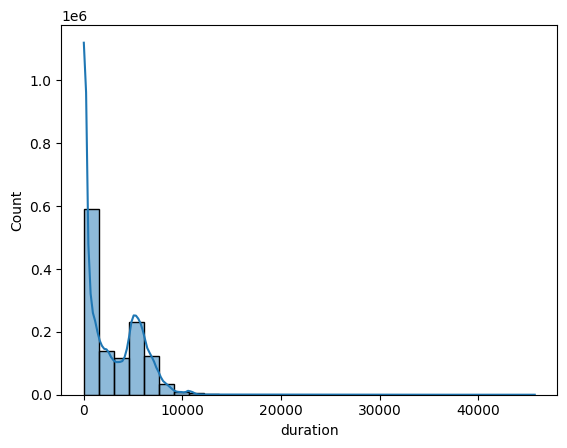

In [15]:
sns.histplot(data=interactions, x="duration", bins=30, kde=True)

<Axes: xlabel='duration', ylabel='Count'>

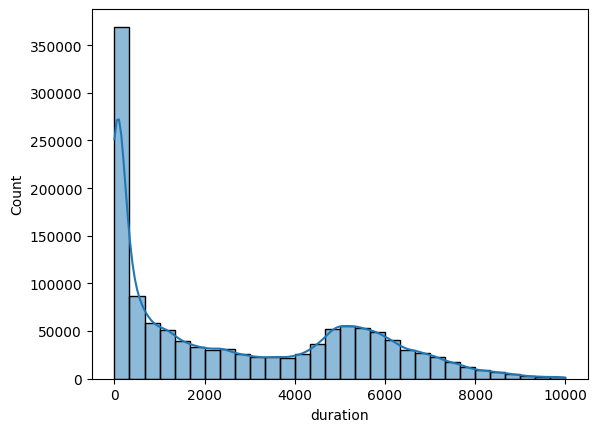

In [16]:
sns.histplot(
    data=interactions[interactions["duration"] < 10000], x="duration", bins=30, kde=True
)

Один бин на гистограмме равен 2000/6 ~ 333 (около 5.5 минут). Мы видим, что многие люди начинают что-то смотреть, но часто не заканчивают. Давайте в качестве веса взаимодействия установим отсечку 700 (2 бина на гистограмме), что означает, что человек посмотрел больше 11 минут. Кажется, что это неплохая эвристика для старта, т.к. по гистограмме видно, что большая часть людей после этого времени отсеивается. В дальнейшем можно будет подобрать порог как гиперпараметр, а ещё лучше - спарсить данные по длительности фильмов и считать процент просмотра. Если бы были данные с кликов или иные взаимодействия пользователя и фильма - можно было бы добавить сюда же (в вес взаимодействия, который отражает заинтересованность пользователя фильмом)

In [17]:
interactions["weight"] = (interactions["duration"] > 700).astype(int)

In [18]:
interactions

,datetime,user_id,movie_id,duration,weight
0,2023-04-06 12:00:00,10250,427.0,485.0,0
1,2023-04-06 12:00:01,2062,1521.0,129.0,0
2,2023-04-06 12:00:03,12980,4598.0,2795.0,1
3,2023-04-06 12:00:04,30646,5324.0,5094.0,1
4,2023-04-06 12:00:10,43069,4291.0,75.0,0
...,...,...,...,...,...
1251866,2023-06-14 20:59:02,31874,7367.0,770.0,1
1251867,2023-06-14 20:59:06,74122,1847.0,2908.0,1
1251868,2023-06-14 20:59:33,112950,2784.0,345.0,0
1251869,2023-06-14 20:59:50,34303,1520.0,2021.0,1


In [19]:
# TODO временно удаляем duration, пока неизвестна общая продолжительность фильма
interactions = interactions.drop("duration", axis=1)

interactions.rename(
    columns={
        "last_watch_dt": Columns.Datetime,
        "movie_id": "item_id",
        # 'watched_pct': Columns.Weight,
    },
    inplace=True,
)


In [20]:
interactions

,datetime,user_id,item_id,weight
0,2023-04-06 12:00:00,10250,427.0,0
1,2023-04-06 12:00:01,2062,1521.0,0
2,2023-04-06 12:00:03,12980,4598.0,1
3,2023-04-06 12:00:04,30646,5324.0,1
4,2023-04-06 12:00:10,43069,4291.0,0
...,...,...,...,...
1251866,2023-06-14 20:59:02,31874,7367.0,1
1251867,2023-06-14 20:59:06,74122,1847.0,1
1251868,2023-06-14 20:59:33,112950,2784.0,0
1251869,2023-06-14 20:59:50,34303,1520.0,1


In [21]:
interactions.describe()

,datetime,user_id,item_id,weight
count,1251871,1.251871e+06,1.251871e+06,1.251871e+06
mean,2023-04-30 17:30:25,4.256487e+04,3.696708e+03,6.303589e-01
min,2023-04-06 12:00:00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2023-04-16 18:15:39,5.954000e+03,1.871000e+03,0.000000e+00
50%,2023-04-29 09:18:05,1.968700e+04,3.672000e+03,1.000000e+00
75%,2023-05-12 08:02:06,5.533800e+04,5.584000e+03,1.000000e+00
max,2023-06-14 20:59:57,2.638740e+05,7.426000e+03,1.000000e+00
std,NaN,5.535238e+04,2.129806e+03,4.827077e-01


Видим, что единиц в weight у нас 63%, вполне нормальный результат для начальной эвристики

# Users

In [22]:
users

,user_id,age_category,income,sex,kids_flg,education
0,10250,35-44,NaN,NaN,0.0,Высшее
1,2062,18-24,NaN,Женский,0.0,Среднее
2,12980,35-44,NaN,Женский,1.0,Неполное высшее
3,30646,35-44,низкий,NaN,1.0,Высшее
4,43069,25-34,NaN,Женский,NaN,Высшее
...,...,...,...,...,...,...
207372,224150,45-54,средний,Женский,1.0,Высшее
207373,227931,35-44,NaN,NaN,1.0,NaN
207374,143732,18-24,NaN,Женский,0.0,Среднее
207375,58404,25-34,низкий,Женский,1.0,Среднее


Посмотрим, сколько фильмов смотрят пользователи

In [23]:
user_watched_films = (
    interactions[["item_id", "user_id"]]
    .groupby("user_id")["item_id"]
    .agg("count")
    .to_frame()
)
user_watched_films.rename(columns={"item_id": "watched_films_number"}, inplace=True)
user_watched_films.sample(5)

,watched_films_number
user_id,
46809,3
31646,8
91058,4
42648,13
52307,3


In [24]:
user_watched_films.describe()

,watched_films_number
count,207377.000000
mean,6.036692
std,12.294655
min,1.000000
25%,1.000000
50%,2.000000
75%,5.000000
max,782.000000


Видим, что у нас очень много холодных пользователей, у которых мало просмотров. Это в очередной раз подтверждает, что популярные фильмы здесь будут являться сильным бейзлайном. Будем использовать двухуровневую модель, и в моделях первого уровня обязательно будет PopularModel. Скорее всего, модель типа ALS будет слабо себя показывать, поскольку лучше работает с горячими пользователями, поэтому попробуем лучше LightFM.

In [25]:
def encode_cat_cols(df: pd.DataFrame, cat_cols) -> Tuple[pd.DataFrame, Dict]:
    cat_col_encoding = {}

    for col in cat_cols:
        cat_col = df[col].astype("category").cat
        cat_col_encoding[col] = cat_col.categories
        df[col] = cat_col.codes.astype("category")
    return df, cat_col_encoding


users_cat_cols = ["age_category", "income", "sex", "kids_flg", "education"]

In [26]:
users.sample(3)

,user_id,age_category,income,sex,kids_flg,education
58088,67846,35-44,NaN,Женский,1.0,Среднее
137034,149453,18-24,NaN,NaN,0.0,Высшее
197874,198546,35-44,низкий,Мужской,1.0,Неполное высшее


In [27]:
# Распределение по возрастным категориям (age_category)
age_distribution = users["age_category"].value_counts()

# Распределение по уровню дохода (income)
income_distribution = users["income"].value_counts()

# Распределение по полу (sex)
sex_distribution = users["sex"].value_counts()

# Распределение по флагу наличия детей (kids_flg)
kids_distribution = users["kids_flg"].value_counts()

# Распределение по уровню образования (education)
education_distribution = users["education"].value_counts()

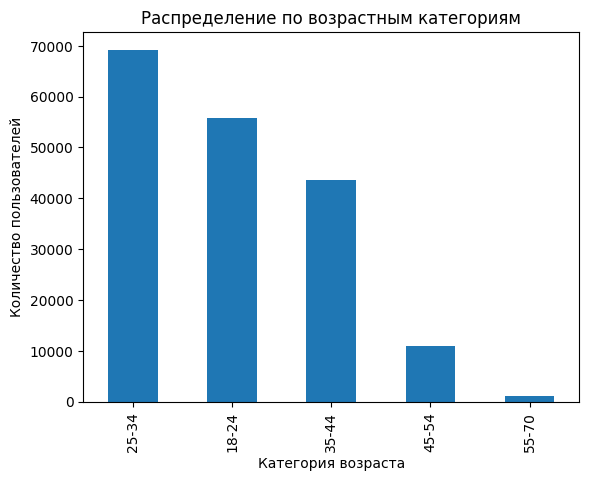

In [28]:
age_distribution.plot(kind="bar")
plt.title("Распределение по возрастным категориям")
plt.xlabel("Категория возраста")
plt.ylabel("Количество пользователей")
plt.show()

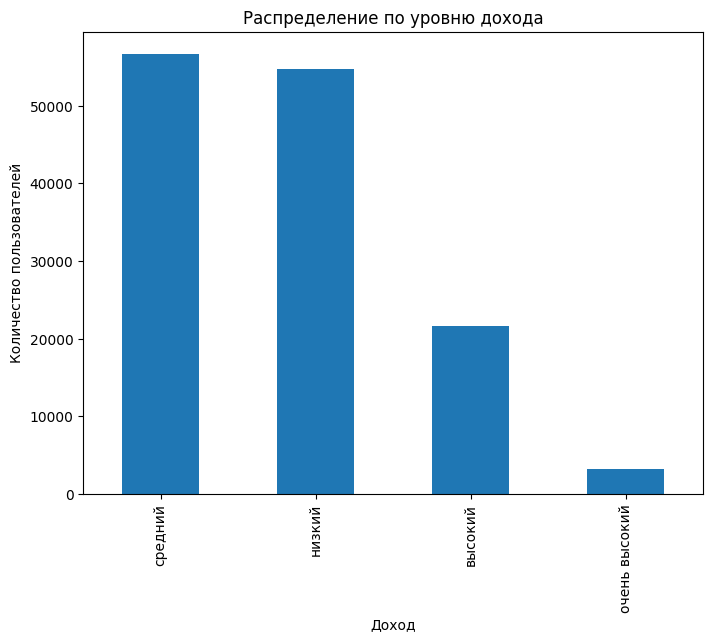

In [29]:
plt.figure(figsize=(8, 6))
income_distribution.plot(kind="bar")
plt.title("Распределение по уровню дохода")
plt.xlabel("Доход")
plt.ylabel("Количество пользователей")
plt.show()

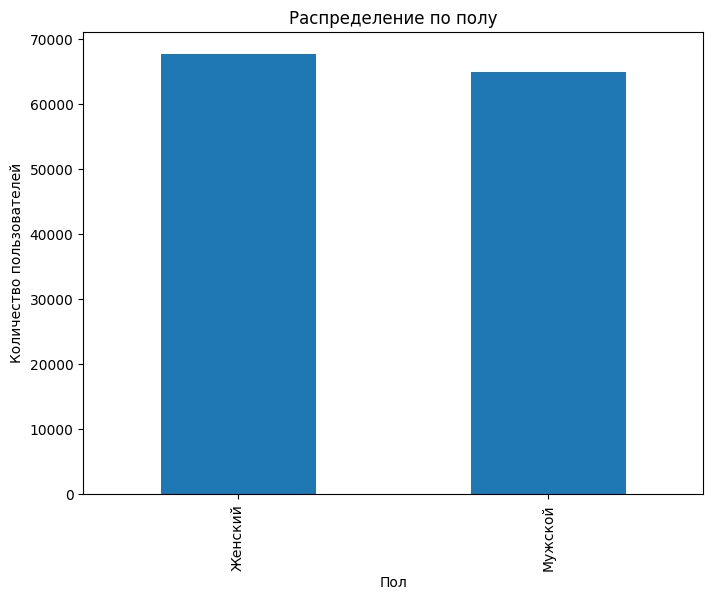

In [30]:
plt.figure(figsize=(8, 6))
sex_distribution.plot(kind="bar")
plt.title("Распределение по полу")
plt.xlabel("Пол")
plt.ylabel("Количество пользователей")
plt.show()

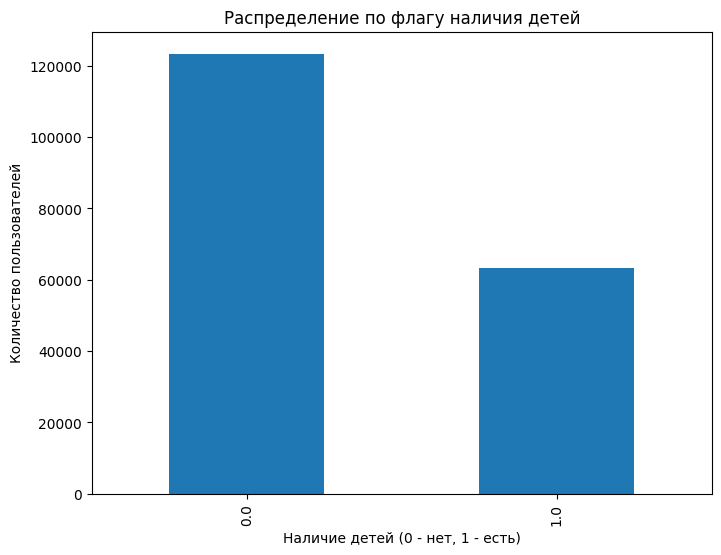

In [31]:
plt.figure(figsize=(8, 6))
kids_distribution.plot(kind="bar")
plt.title("Распределение по флагу наличия детей")
plt.xlabel("Наличие детей (0 - нет, 1 - есть)")
plt.ylabel("Количество пользователей")
plt.show()

Видим, что в целом дети есть у значимого кол-ва пользователей, значит мультфильмы в целом могут быть актуальны. К сожалению, в данных нет флага мультфильм, это могло бы помочь

In [32]:
# TODO собрать информацию по мультфильмам

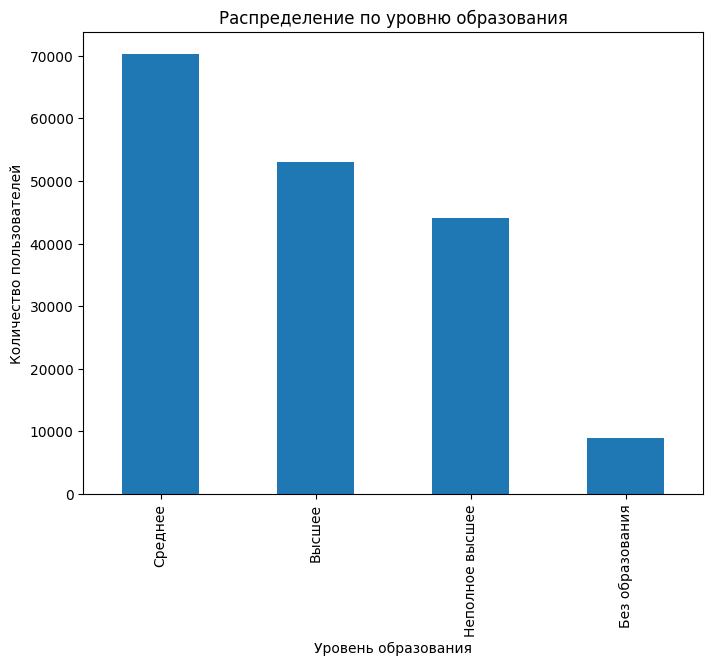

In [33]:
plt.figure(figsize=(8, 6))
education_distribution.plot(kind="bar")
plt.title("Распределение по уровню образования")
plt.xlabel("Уровень образования")
plt.ylabel("Количество пользователей")
plt.show()

In [34]:
# None кодируется как -1
users, users_cat_col_encoding = encode_cat_cols(users, users_cat_cols)
users_cat_col_encoding["income"], users["income"].unique()

(Index(['высокий', 'низкий', 'очень высокий', 'средний'], dtype='object'),
 [-1, 1, 3, 0, 2]
 Categories (5, int8): [-1, 0, 1, 2, 3])

In [35]:
users.describe(include="category")

,age_category,income,sex,kids_flg,education
count,207377,207377,207377,207377,207377
unique,6,5,3,3,5
top,1,-1,-1,0,3
freq,69235,71142,74754,123382,70253


У большинства пользователей не указан доход и пол, это может негативно сказаться на предсказаниях

# Items

In [36]:
# TODO разделить staff на directors и actors
# TODO добавить инфу про студии
# TODO добавить инфу про тип контента (фильм, сериал, ...)
# TODO добавить суммарную популярность актёров / режиссеров

In [37]:
items

,id,title,year,date_publication,description,genres,countries,staff,title_orig,age_rating,keywords
0,0,"Мама, я дома",2022-01-01,2022-11-23T00:00:00,Где-то в глубинке вместе с дочерью и внуком жи...,[97],[238],"[1883, 33655, 25890, 1001, 12051, 10110, 16895]",NaN,NaN,NaN
1,1,Три метра над уровнем неба,2010-01-01,NaN,"История любви парня и девушки, принадлежащих к...","[138, 97, 294]",[242],"[18168, 23444, 10850, 21847, 30555, 24469, 268...",Tres metros sobre el cielo,16.0,"Три, метра, над, уровнем, неба, 2010, Испания,..."
2,2,Детектив ди и тайна призрачного пламени,2010-01-01,NaN,"690 год нашей эры, Китай. Первая императрица д...","[294, 302]","[250, 117]","[3933, 19953, 32174, 30640, 14127, 32141, 2549...",NaN,NaN,NaN
3,3,Капитан,2017-01-01,2022-10-20T00:00:00,Вторая мировая война подходит к концу. В это в...,"[97, 303, 143, 319]","[188, 212, 0]","[16006, 12217, 30668, 28806, 16172, 5045, 1663...",NaN,NaN,NaN
4,4,Лазурный берег,2015-01-01,2023-01-12T00:00:00,У бывшей танцовщицы Ванессы и писателя Роланда...,"[138, 97]","[1, 102, 0]","[23586, 8823, 8040, 34555, 32484, 18446]",By the Sea,18.0,"Франция, отель, 1970-е, горе, путешествие, нес..."
...,...,...,...,...,...,...,...,...,...,...,...
7422,7422,Ромео + Джульетта,1996-01-01,2023-03-03T00:00:00,"Переосмысление знаменитой истории Шекспира, пе...","[138, 97]","[49, 102]","[31732, 12514, 5845, 12650, 23433, 28088, 64, ...",Romeo + Juliet,12.0,"запретная любовь, основанная на пьесе или мюзи..."
7423,7423,"Поймай меня, если сможешь",2002-01-01,2020-03-27T07:13:01.449866,"Фрэнк Эбэгнейл успел поработать врачом, адвока...","[85, 303]","[121, 102]","[5166, 24667, 6277, 8266, 4854, 2186, 29049, 6...",Catch Me If You Can,12.0,"ФБР, аферист, биография, основано на реальных ..."
7424,7424,Молодой Годар,2017-01-01,NaN,"Париж, 1967 год. Жан-Люк Годар - лидер «новой ...","[138, 85]",[0],"[5828, 24468, 5125, 19939, 12752, 21851, 22674...",Le Redoubtable,18.0,"Молодой, Годар, 2017, Франция, брак, знаменито..."
7425,7425,Юлия Колерт — «Окна»,2023-01-01,2023-06-01T00:00:00,Юлия Колерт \n«Окна»\nКоличество просмотров*: ...,[247],[238],[],NaN,NaN,NaN


In [38]:
items[items["countries"].isna()]

,id,title,year,date_publication,description,genres,countries,staff,title_orig,age_rating,keywords


In [39]:
items[items["staff"].isna()]

,id,title,year,date_publication,description,genres,countries,staff,title_orig,age_rating,keywords


In [40]:
items[items["genres"].isna()]

,id,title,year,date_publication,description,genres,countries,staff,title_orig,age_rating,keywords


К сожалению, в айтемах не указан id фильма (как user_id в users), будем считать, что за это отвечает столбец id. Будет печально, если это не так

In [41]:
items.rename(
    columns={"id": "item_id"},
    inplace=True,
)

In [42]:
items["for_kids"] = (items["age_rating"] < 16).astype(int)

In [43]:
items["year"] = pd.to_datetime(items["year"]).dt.year

In [44]:
# Аналогичным образом кодируем категориальные колонки и пока удаляем текстовые и те, где собрано много всего
items_cat_cols = [
    "for_kids",
]
items_text_cols = [
    "title",
    "title_orig",
    "description",
    "keywords",
]
items_num_cols = [
    "year",
    "age_rating",
]
default_values_items = {
    "year": items["year"].median(),
    "age_rating": items["age_rating"].median(),
    "genres": "[]",
    "countries": "[]",
    "staff": "[]",
}


items, items_cat_col_encoding = encode_cat_cols(items, items_cat_cols)
items_titles = items[["item_id", "title"]]
items = items.drop(items_text_cols, axis=1)
items.fillna(default_values_items, inplace=True)

то, что сейчас genres, countries и staff закодированы строками, хотя по факту это массивы - это нормально, разберемся с этим чуть ниже

In [45]:
items.describe(include="all")

,item_id,year,date_publication,genres,countries,staff,age_rating,for_kids
count,7427.000000,7427.000000,4923,7427,7427,7427,7427.000000,7427.0
unique,NaN,NaN,576,862,586,6258,NaN,2.0
top,NaN,NaN,2023-01-12T00:00:00,[97],[102],[],NaN,0.0
freq,NaN,NaN,628,529,2158,816,NaN,6186.0
mean,3713.000000,2008.498048,NaN,NaN,NaN,NaN,14.961223,NaN
std,2144.134557,16.401058,NaN,NaN,NaN,NaN,3.422703,NaN
min,0.000000,1895.000000,NaN,NaN,NaN,NaN,0.000000,NaN
25%,1856.500000,2005.000000,NaN,NaN,NaN,NaN,16.000000,NaN
50%,3713.000000,2014.000000,NaN,NaN,NaN,NaN,16.000000,NaN
75%,5569.500000,2019.000000,NaN,NaN,NaN,NaN,16.000000,NaN


# Трейн-вал-тест сплит

In [46]:
max_date = interactions[Columns.Datetime].max()
min_date = interactions[Columns.Datetime].min()

print(f"min дата в interactions: {min_date}")
print(f"max дата в interactions: {max_date}")
print(f"Продолжительность: {max_date - min_date}")

min дата в interactions: 2023-04-06 12:00:00
max дата в interactions: 2023-06-14 20:59:57
Продолжительность: 69 days 08:59:57


69 дней данных не так уж и много, данных мб мало. С другой стороны, сезонных тенденций будет не так много, это может отчасти сделать задачу легче

Разбивать трейн будем следующим образом. Данная схема максимально подходит для первого вывода двухуровневой модели в production и не допускает утечки данных (через модели первого уровня) по времени.  
  
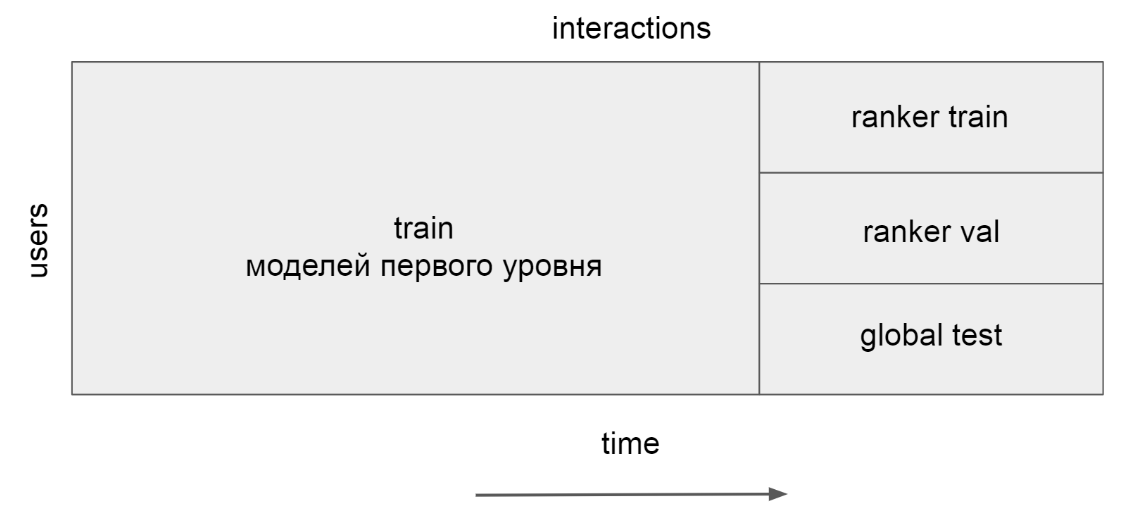

Стоит заметить, что на изображении тест - это не test_data.csv. Эти итоговые тестовые данные будем считать данными с прода :)

In [47]:
ranker_days_count = 15

ranker_data = interactions[
    (interactions[Columns.Datetime] >= max_date - pd.Timedelta(days=ranker_days_count))
]

train_size = 0.7
val_size = 0.15
test_size = 0.15

# TODO можно задать стратификацию по разным параметрам

train_val_users, test_users = train_test_split(
    ranker_data["user_id"].unique(), random_state=42, test_size=test_size
)

train_users, val_users = train_test_split(
    train_val_users,
    random_state=42,
    test_size=val_size / (train_size + val_size),  # 15% от общего размера
)

In [48]:
base_models_data = interactions[
    (interactions[Columns.Datetime] < max_date - pd.Timedelta(days=ranker_days_count))
]

In [49]:
base_models_data

,datetime,user_id,item_id,weight
0,2023-04-06 12:00:00,10250,427.0,0
1,2023-04-06 12:00:01,2062,1521.0,0
2,2023-04-06 12:00:03,12980,4598.0,1
3,2023-04-06 12:00:04,30646,5324.0,1
4,2023-04-06 12:00:10,43069,4291.0,0
...,...,...,...,...
1182637,2023-05-30 20:57:38,163029,4176.0,1
1182638,2023-05-30 20:57:41,204603,5330.0,0
1182639,2023-05-30 20:57:47,247495,4754.0,1
1182640,2023-05-30 20:58:18,171141,3323.0,0


# Обучаем модели первого уровня

### Подготовим датасет для обучения моделей первого уровня

In [50]:
users

,user_id,age_category,income,sex,kids_flg,education
0,10250,2,-1,-1,0,1
1,2062,0,-1,0,0,3
2,12980,2,-1,0,1,2
3,30646,2,1,-1,1,1
4,43069,1,-1,0,-1,1
...,...,...,...,...,...,...
207372,224150,3,3,0,1,1
207373,227931,2,-1,-1,1,-1
207374,143732,0,-1,0,0,3
207375,58404,1,1,0,1,3


In [51]:
# users_train = users.loc[users[Columns.User].isin(base_models_data[Columns.User])].copy()
user_feature_frames = []
for feature in ["sex", "age_category", "income", "kids_flg", "education"]:
    feature_frame = users.reindex(columns=[Columns.User, feature])  # users_train ?
    feature_frame.columns = ["id", "value"]
    feature_frame["feature"] = feature
    user_feature_frames.append(feature_frame)
user_features = pd.concat(user_feature_frames)

In [52]:
user_features

,id,value,feature
0,10250,-1,sex
1,2062,0,sex
2,12980,0,sex
3,30646,-1,sex
4,43069,0,sex
...,...,...,...
207372,224150,1,education
207373,227931,-1,education
207374,143732,3,education
207375,58404,3,education


In [53]:
items["genres"] = items["genres"].str.strip("][").str.split(", ")
items["countries"] = items["countries"].str.strip("][").str.split(", ")
items["staff"] = items["staff"].str.strip("][").str.split(", ")

In [54]:
type(items["genres"][0])  # теперь нормальные списки

list

In [55]:
# explode genres to flatten table

genre_feature = items[["item_id", "genres"]].explode("genres")
genre_feature.columns = ["id", "value"]
genre_feature["feature"] = "genre"
genre_feature["value"].value_counts()

value
97     1990
46     1566
85     1023
303     928
294     826
       ... 
292       1
347       1
165       1
91        1
210       1
Name: count, Length: 97, dtype: int64

In [56]:
genre_feature

,id,value,feature
0,0,97,genre
1,1,138,genre
1,1,97,genre
1,1,294,genre
2,2,294,genre
...,...,...,...
7423,7423,303,genre
7424,7424,138,genre
7424,7424,85,genre
7425,7425,247,genre


In [57]:
# explode countries to flatten table

countries_feature = items[["item_id", "countries"]].explode("countries")
countries_feature.columns = ["id", "value"]
countries_feature["feature"] = "country"
countries_feature["value"].value_counts()

value
102    3338
238    1842
122     772
205     722
0       642
       ... 
209       1
88        1
155       1
91        1
112       1
Name: count, Length: 101, dtype: int64

In [58]:
# explode staff to flatten table

staff_feature = items[["item_id", "staff"]].explode("staff")
staff_feature.columns = ["id", "value"]
staff_feature["feature"] = "staff"
staff_feature["value"].value_counts()

value
         816
19174    172
34803    169
7617     169
8361      44
        ... 
6164       1
17471      1
1965       1
13882      1
16248      1
Name: count, Length: 35685, dtype: int64

In [59]:
year_feature = items.reindex(columns=[Columns.Item, "year"])
year_feature.columns = ["id", "value"]
year_feature["feature"] = "year"

age_feature = items.reindex(columns=[Columns.Item, "age_rating"])
age_feature.columns = ["id", "value"]
age_feature["feature"] = "age_rating"

kids_feature = items.reindex(columns=[Columns.Item, "for_kids"])
kids_feature.columns = ["id", "value"]
kids_feature["feature"] = "for_kids"

In [60]:
item_features = pd.concat(
    (
        genre_feature,
        countries_feature,
        staff_feature,
        age_feature,
        kids_feature,
        year_feature,
    )
)

In [61]:
items.head(1)

,item_id,year,date_publication,genres,countries,staff,age_rating,for_kids
0,0,2022,2022-11-23T00:00:00,[97],[238],"[1883, 33655, 25890, 1001, 12051, 10110, 16895]",16.0,0


In [62]:
dataset_pop_lightfm = rectools.dataset.Dataset.construct(
    interactions_df=base_models_data,
    user_features_df=user_features,
    cat_user_features=["sex", "age_category", "income", "kids_flg", "education"],
    item_features_df=item_features,
    cat_item_features=["genre", "country", "year", "staff", "age_rating", "for_kids"],
)

## LightFM

In [63]:
# TODO затюнить параметры через optuna

In [64]:
%%time
model = LightFMWrapperModel(
    LightFM(no_components=10, loss="warp", max_sampled=5, random_state=42),
    epochs=100,
    num_threads=8,
)
model.fit(dataset_pop_lightfm)

CPU times: user 17min 58s, sys: 1.58 s, total: 17min 59s
Wall time: 2min 15s


Сделаем предсказания для всех юзеров (реализация rectools позволяет работать и с горячими, и тёплыми, и холодными пользователями). В дальнейшем уже будем отфильтровывать пользователей, если это понадобится. Кстати, в нашем датасете пользователи в interactions и в users одинаковые, а в тесте нет новых:

In [65]:
users_set = set(users["user_id"].unique())
train_set = set(interactions["user_id"].unique())
test_set = set(test_data["user_id"].unique())

print(users_set == train_set)
print(test_set == train_set)
print(len(test_set - train_set))
print(len(train_set - test_set))

True
False
0
140477


In [66]:
%%time
recos_lightfm = model.recommend(
    users=users["user_id"].unique(),
    dataset=dataset_pop_lightfm,
    k=100,  # здесь k=100 чтобы у ранкера было больше данных от моделей 1 уровня
    filter_viewed=False,  # TODO проверить
)

CPU times: user 27.6 s, sys: 42.3 s, total: 1min 9s
Wall time: 15.7 s


In [67]:
recos_lightfm.head(3)

,user_id,item_id,score,rank
0,10250,484.0,-1669.157349,1
1,10250,451.0,-1669.452515,2
2,10250,1083.0,-1669.549927,3


In [68]:
def convert_recos(
    recos, rename_str, k=10
):  # здесь k=10 как раз отвечает за кол-во рекомендаций перед расчётом ndcg
    result_recos_test = (
        recos.groupby("user_id")["item_id"]
        .apply(list)
        .apply(lambda x: x[:k])
        .reset_index()
        .rename({"item_id": rename_str}, axis=1)
    )
    return result_recos_test

In [69]:
result_recos_test = convert_recos(recos_lightfm, "lightfm_recos")

In [70]:
lfm_candidates = recos_lightfm.rename(
    {"score": "lfm_score", "rank": "lfm_rank"}, axis=1
)

In [71]:
merged_test = pd.merge(test_data, result_recos_test, on="user_id", how="left")

In [72]:
def ndcg_metric(gt_items: np.ndarray, predicted: np.ndarray) -> float:
    at = len(predicted)
    relevance = np.array([1 if x in predicted else 0 for x in gt_items])
    # DCG uses the relevance of the recommended items
    rank_dcg = dcg(relevance)
    if rank_dcg == 0.0:
        return 0.0

    # IDCG has all relevances to 1 (or the values provided), up to the number of items in the test set that can fit in the list length
    ideal_dcg = dcg(np.sort(relevance)[::-1][:at])

    if ideal_dcg == 0.0:
        return 0.0

    ndcg_ = rank_dcg / ideal_dcg

    return ndcg_


def dcg(scores: np.ndarray) -> float:
    return np.sum(
        np.divide(
            np.power(2, scores) - 1,
            np.log2(np.arange(scores.shape[0], dtype=np.float64) + 2),
        ),
        dtype=np.float64,
    )


def recall_metric(gt_items: np.ndarray, predicted: np.ndarray) -> float:
    n_gt = len(gt_items)
    intersection = len(set(gt_items).intersection(set(predicted)))
    return intersection / n_gt


def evaluate_recommender(
    df: pd.DataFrame, model_preds_col: str, gt_col: str = "movie_id"
) -> Dict[str, float]:
    metric_values = []

    for _, row in df.iterrows():
        metric_values.append(
            (
                ndcg_metric(row[gt_col], row[model_preds_col]),
                recall_metric(row[gt_col], row[model_preds_col]),
            )
        )

    return {
        "ndcg": np.mean([x[0] for x in metric_values]),
        "recall": np.mean([x[1] for x in metric_values]),
    }

In [73]:
evaluate_recommender(
    df=merged_test, model_preds_col="lightfm_recos", gt_col="item_ids"
)  # 100 рекомендаций, 100 эпох, 10 компонент, ранкер 15 дней

{'ndcg': 0.08221231459381445, 'recall': 0.038269079196678685}

Проанализируем рекомендации

In [74]:
merged_test.sample(3)

,user_id,item_ids,lightfm_recos
10022,10805,"[794.0, 7426.0, 2409.0, 4695.0, 4176.0, 3859.0...","[6981.0, 484.0, 5779.0, 3895.0, 1978.0, 3397.0..."
54853,89682,[641.0],"[484.0, 6194.0, 2679.0, 2074.0, 2480.0, 1978.0..."
5849,6170,"[6898.0, 4687.0, 6355.0, 5490.0, 1193.0, 3924....","[4469.0, 4254.0, 3829.0, 3851.0, 3315.0, 6781...."


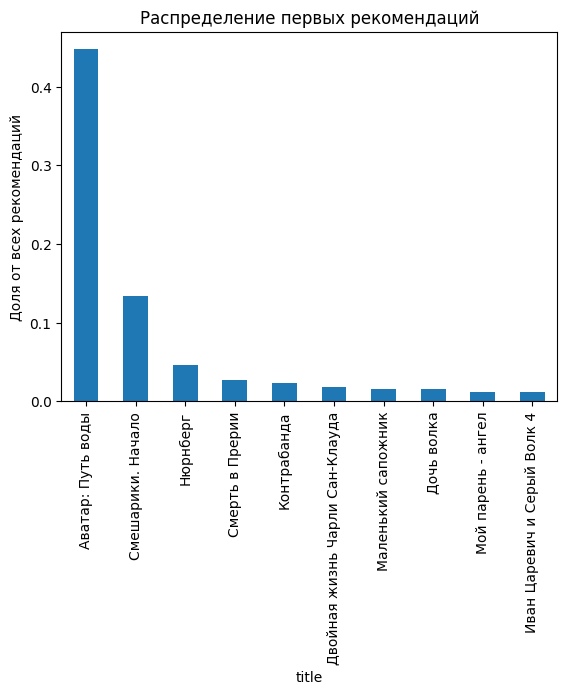

In [75]:
first_recos = pd.DataFrame(
    [x[0] for x in merged_test["lightfm_recos"].values], columns=["item_id"]
)
first_items = (
    first_recos.merge(items_titles, on="item_id")
    .groupby("title")
    .size()
    .sort_values(ascending=False)
)
first_items /= first_items.sum()
first_items.head(10).plot(kind="bar")
plt.ylabel("Доля от всех рекомендаций")
plt.title("Распределение первых рекомендаций")
plt.show()

Аватар на тот момент был максимально популярным и ожидаемым, так что логично, что он первый в рекомендациях. В целом, у других фильмов из топ-5 рекомендаций тоже неплохая доля, скорее всего это для тех, кто уже успел на тот момент посмотреть аватара.
В целом одбряем рекомендацию смешариков :)

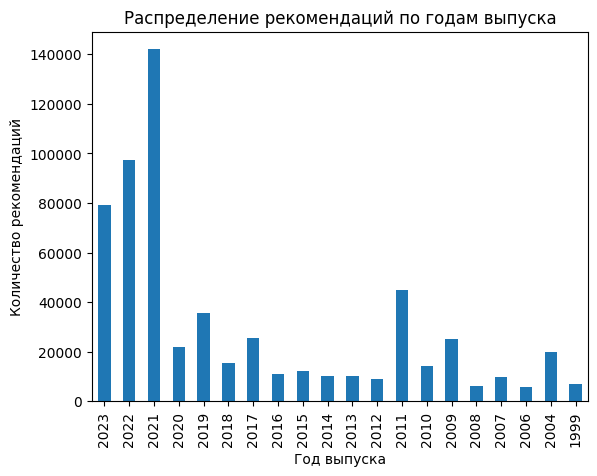

In [76]:
year_distribution = merged_test.explode("lightfm_recos").merge(
    items[["item_id", "year"]], left_on="lightfm_recos", right_on="item_id"
)
year_distribution["year"].value_counts().nlargest(20).sort_index(ascending=False).plot(
    kind="bar"
)

plt.ylabel("Количество рекомендаций")
plt.xlabel("Год выпуска")
plt.title("Распределение рекомендаций по годам выпуска")
plt.show()

Видим, что много рекомендаций за 2021 - 2023 год и, неожиданно, за 2011

In [77]:
# TODO посмотреть какие фильмы из 2011 были рекомендованы. Возможно, это какие-то мультики

## Popular

In [78]:
pop_model = PopularModel()
pop_model.fit(dataset_pop_lightfm)

In [79]:
recos_popular = pop_model.recommend(
    users=users["user_id"].unique(),
    dataset=dataset_pop_lightfm,
    k=100,
    filter_viewed=False,  # TODO проверить
)

In [80]:
result_recos_test = convert_recos(recos_popular, "popular_recos")

In [81]:
popular_candidates = recos_popular.rename(
    {"score": "pop_score", "rank": "pop_rank"}, axis=1
)

In [82]:
result_recos_test

,user_id,popular_recos
0,0,"[484.0, 6194.0, 2679.0, 5876.0, 5336.0, 2074.0..."
1,1,"[484.0, 6194.0, 2679.0, 5876.0, 5336.0, 2074.0..."
2,2,"[484.0, 6194.0, 2679.0, 5876.0, 5336.0, 2074.0..."
3,3,"[484.0, 6194.0, 2679.0, 5876.0, 5336.0, 2074.0..."
4,4,"[484.0, 6194.0, 2679.0, 5876.0, 5336.0, 2074.0..."
...,...,...
207372,263866,"[484.0, 6194.0, 2679.0, 5876.0, 5336.0, 2074.0..."
207373,263868,"[484.0, 6194.0, 2679.0, 5876.0, 5336.0, 2074.0..."
207374,263870,"[484.0, 6194.0, 2679.0, 5876.0, 5336.0, 2074.0..."
207375,263873,"[484.0, 6194.0, 2679.0, 5876.0, 5336.0, 2074.0..."


In [83]:
merged_test = pd.merge(merged_test, result_recos_test, on="user_id", how="left")

In [84]:
merged_test

,user_id,item_ids,lightfm_recos,popular_recos
0,0,"[12.0, 6201.0, 5542.0, 2025.0, 190.0, 5358.0, ...","[4469.0, 1996.0, 4254.0, 4176.0, 5466.0, 6195....","[484.0, 6194.0, 2679.0, 5876.0, 5336.0, 2074.0..."
1,1,"[2515.0, 1540.0, 5210.0, 1608.0, 3590.0, 7215....","[5779.0, 484.0, 1978.0, 5707.0, 5918.0, 5876.0...","[484.0, 6194.0, 2679.0, 5876.0, 5336.0, 2074.0..."
2,2,"[5998.0, 190.0, 7327.0, 947.0, 3814.0, 876.0, ...","[484.0, 6194.0, 2480.0, 2679.0, 2074.0, 1978.0...","[484.0, 6194.0, 2679.0, 5876.0, 5336.0, 2074.0..."
3,3,"[4812.0, 3935.0, 802.0, 4459.0, 4340.0, 5975.0...","[4469.0, 2997.0, 4581.0, 6172.0, 4308.0, 5512....","[484.0, 6194.0, 2679.0, 5876.0, 5336.0, 2074.0..."
4,4,"[152.0, 195.0, 800.0, 2266.0, 6634.0, 7412.0, ...","[4469.0, 3812.0, 444.0, 3434.0, 810.0, 4687.0,...","[484.0, 6194.0, 2679.0, 5876.0, 5336.0, 2074.0..."
...,...,...,...,...
66895,176506,[1515.0],"[6241.0, 7339.0, 1522.0, 6402.0, 1164.0, 453.0...","[484.0, 6194.0, 2679.0, 5876.0, 5336.0, 2074.0..."
66896,176519,[4167.0],"[4469.0, 4254.0, 1226.0, 484.0, 451.0, 2820.0,...","[484.0, 6194.0, 2679.0, 5876.0, 5336.0, 2074.0..."
66897,176525,[5947.0],"[6194.0, 5336.0, 4090.0, 484.0, 5712.0, 1281.0...","[484.0, 6194.0, 2679.0, 5876.0, 5336.0, 2074.0..."
66898,176531,[5514.0],"[6194.0, 484.0, 5336.0, 4090.0, 5712.0, 1281.0...","[484.0, 6194.0, 2679.0, 5876.0, 5336.0, 2074.0..."


In [85]:
evaluate_recommender(
    df=merged_test, model_preds_col="popular_recos", gt_col="item_ids"
)  # 100 рекомендаций, ранкер 15 дней

{'ndcg': 0.08071575541377207, 'recall': 0.03563382489856545}

Видим, что в целом на тестовом сете lightfm показывает себя лучше, чем популярное. Метрики популярного здесь ниже, чем в intro-ноутбуке, так как обе модели (lightfm и популярное) здесь обучаются только на части тренировочного сета, оставшиеся дни - данные для модели второго уровня, чтобы не допустить лика по времени. Если обучать модели первого уровня на всех имеющихся данных, то модель-ранкер будет учиться на тех данных, которые уже были выучены моделями первого уровня, что отличается от потеницального использования в проде, это и будет образовывать дата-лик по времени. В связи с этим придётся пожертвовать количеством данных для моделей первого уровня

In [86]:
# Проанализируем рекомендации популярного

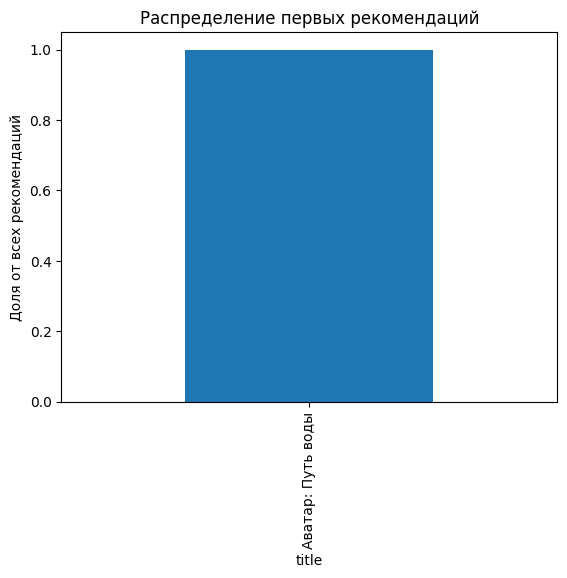

In [87]:
first_recos = pd.DataFrame(
    [x[0] for x in merged_test["popular_recos"].values], columns=["item_id"]
)
first_items = (
    first_recos.merge(items_titles, on="item_id")
    .groupby("title")
    .size()
    .sort_values(ascending=False)
)
first_items /= first_items.sum()
first_items.head(10).plot(kind="bar")
plt.ylabel("Доля от всех рекомендаций")
plt.title("Распределение первых рекомендаций")
plt.show()

Тут ожидаемо всем рекомендуем в первую очередь аватара :)

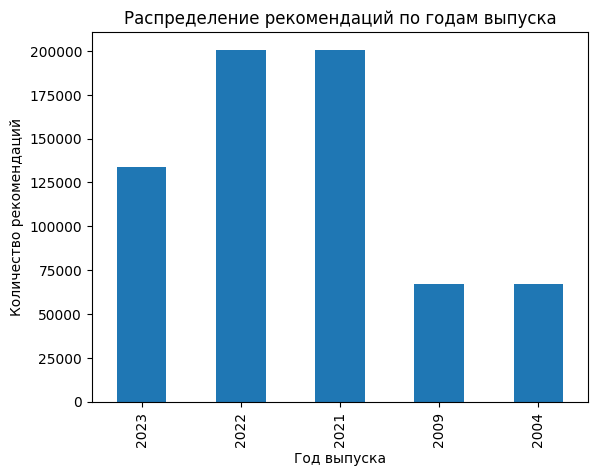

In [88]:
year_distribution = merged_test.explode("popular_recos").merge(
    items[["item_id", "year"]], left_on="popular_recos", right_on="item_id"
)
year_distribution["year"].value_counts().nlargest(20).sort_index(ascending=False).plot(
    kind="bar"
)

plt.ylabel("Количество рекомендаций")
plt.xlabel("Год выпуска")
plt.title("Распределение рекомендаций по годам выпуска")
plt.show()

Видим, что по большей части популярные фильмы с 2021 по 2023 год, что ожидаемо

Теперь сформируем таблицу кандидатов от моделей первого уровня

In [89]:
popular_candidates.sample(3)

,user_id,item_id,pop_score,pop_rank
9818650,113327,1451.0,2048.0,51
5446009,63955,2480.0,3873.0,10
4858913,39078,4687.0,3351.0,14


In [90]:
lfm_candidates.sample(3)

,user_id,item_id,lfm_score,lfm_rank
8984449,119721,5256.0,-1437.908203,50
10760396,203623,3560.0,-1635.825562,97
5946485,66980,6904.0,-1613.662598,86


In [91]:
candidates = pd.merge(
    lfm_candidates, popular_candidates, on=["user_id", "item_id"], how="outer"
)
lfm_min_score: float = candidates["lfm_score"].min() - 0.01
lfm_max_rank: int = candidates["lfm_rank"].max() + 1

pop_min_score: float = candidates["pop_score"].min() - 0.01
pop_max_rank: int = candidates["pop_rank"].max() + 1

default_values = {
    "lfm_score": lfm_min_score,
    "lfm_rank": lfm_max_rank,
    "pop_score": pop_min_score,
    "pop_rank": pop_max_rank,
    **interactions_default_values,
}

candidates.fillna(default_values, inplace=True)

candidates.head()

,user_id,item_id,lfm_score,lfm_rank,pop_score,pop_rank
0,0,65.0,-1800.806265,101.0,1901.00,68.0
1,0,74.0,-1561.063477,35.0,1640.99,101.0
2,0,107.0,-1561.179932,41.0,1640.99,101.0
3,0,130.0,-1560.512939,12.0,1640.99,101.0
4,0,158.0,-1800.806265,101.0,2117.00,49.0


In [92]:
candidates.shape  # большая табличка

(32367523, 6)

Давайте посчитаем разные метрики для моделей первого уровня на выборке, которую мы отложили для ранкера (будем считать это валидационной выборкой для моделей первого уровня). Сделаем это через rectools:

In [93]:
def calc_metrics_(candidates_df, rank_col: str) -> Dict[str, float]:
    metrics = {
        "ndcg@10": NDCG(k=10),
        "map@10": MAP(k=10),
        "precision@10": Precision(k=10),
        "recall@10": Recall(k=10),
        "novelty@10": MeanInvUserFreq(k=10),
    }
    return calc_metrics(
        metrics=metrics,
        reco=(
            candidates_df.rename(columns={rank_col: Columns.Rank})[
                [Columns.User, Columns.Item, Columns.Rank]
            ][candidates_df[Columns.User].isin(test_users)]
        ),
        interactions=(
            ranker_data[[Columns.User, Columns.Item, Columns.Datetime, Columns.Weight]][
                ranker_data[Columns.User].isin(test_users)
            ]
        ),
        prev_interactions=(
            base_models_data[
                [Columns.User, Columns.Item, Columns.Datetime, Columns.Weight]
            ][base_models_data[Columns.User].isin(test_users)]
        ),
        catalog=items["item_id"].unique(),
    )


models_metrics: Dict[str, Dict[str, float]] = dict()
models_metrics["lfm"] = calc_metrics_(candidates, "lfm_rank")
models_metrics["pop"] = calc_metrics_(candidates, "pop_rank")

In [94]:
pd.DataFrame(models_metrics)

,lfm,pop
precision@10,0.007490,0.009087
recall@10,0.031963,0.042152
ndcg@10,0.009665,0.010474
map@10,0.015829,0.015813
novelty@10,7.437609,6.927668


Видим, что метрики отличаются от теста, но это нормально, т.к. в этих сетах разные айтемы и даже разные юзеры, что сильно влияет на метрики. Корректно сравнивать здесь мы можем только метрики моделей Lfm и pop на одном промежутке данных. Видим, что метрики lfm чуть лучше, чем популярного (как и на тесте), но не сильно, зато novelty выше. В данном случае novelty это не новизна фильмов, а величина, обратно пропорциональная количеству пользователей, взаимодействоваших с предметами. Т.е. lfm предлагает менее популярные фильмы, при этом сохраняя остальные метрики. Мне кажется, предсказания этой модели могут стать хорошей опорой для предсказаний модели второго уровня.  



Вот выжимка из rectools по поводу novelty (MIUF):

 Mean Inverse User Frequency metric.

Estimate mean novelty of items in recommendations,
where "novelty" of item is inversely proportional
to the number of users who interacted with it.

$$ MIUF@k = -(\sum_{i=1}^{k} \log_{2} (users(i) / n\_users)) / k $$

where
- `users(i)` is number of users that previously interacted with item with rank `i`.
- `n_users` is the overall number of users in previous interactions.

# Формируем датасет для ранкера

Добавим немного фичей для модели второго уровня (они в основном про популярность, поэтому мы не хотим их подавать в модели первого уровня, чтобы они давали более разнообразные рекомендации)

In [95]:
# Получаем длину истории юзера
base_models_data["user_hist"] = base_models_data.groupby("user_id")[
    "item_id"
].transform("count")
# Получаем популярность контента
base_models_data["item_pop"] = base_models_data.groupby("item_id")["user_id"].transform(
    "count"
)
# Получаем среднюю популярность контента, просматриваемого этим юзером
base_models_data["user_avg_pop"] = base_models_data.groupby("user_id")[
    "item_pop"
].transform("mean")
# Получаем среднюю длину истории пользователя, которые смотрит этот контент
base_models_data["item_avg_hist"] = base_models_data.groupby("item_id")[
    "user_hist"
].transform("mean")
# Получаем популярность последнего просмотренного контента
base_models_data.sort_values(
    by=[Columns.User, Columns.Datetime],
    ascending=[True, False],
    ignore_index=True,
    inplace=True,
)
base_models_data["user_last_pop"] = base_models_data.groupby("user_id")[
    "item_pop"
].transform("first")
base_models_data.head(3)

,datetime,user_id,item_id,weight,user_hist,item_pop,user_avg_pop,item_avg_hist,user_last_pop
0,2023-05-21 14:30:34,0,1746.0,0,70,454,361.728571,26.590308,454
1,2023-05-19 16:00:01,0,5822.0,0,70,106,361.728571,37.235849,454
2,2023-05-19 15:47:57,0,6914.0,0,70,105,361.728571,35.904762,454


In [96]:
# Добавляем новые фичи в соответствующие таблички
items = pd.merge(
    left=items,
    right=(
        base_models_data[["item_id", "item_pop", "item_avg_hist"]].drop_duplicates()
    ),
    how="left",
    on="item_id",
)
items.head(3)

,item_id,year,date_publication,genres,countries,staff,age_rating,for_kids,item_pop,item_avg_hist
0,0,2022,2022-11-23T00:00:00,[97],[238],"[1883, 33655, 25890, 1001, 12051, 10110, 16895]",16.0,0,18.0,31.333333
1,1,2010,NaN,"[138, 97, 294]",[242],"[18168, 23444, 10850, 21847, 30555, 24469, 268...",16.0,0,NaN,NaN
2,2,2010,NaN,"[294, 302]","[250, 117]","[3933, 19953, 32174, 30640, 14127, 32141, 2549...",16.0,0,NaN,NaN


In [97]:
users = pd.merge(
    left=users,
    right=(
        base_models_data[
            ["user_id", "user_hist", "user_avg_pop", "user_last_pop"]
        ].drop_duplicates()
    ),
    how="left",
    on="user_id",
)
users.head(3)

,user_id,age_category,income,sex,kids_flg,education,user_hist,user_avg_pop,user_last_pop
0,10250,2,-1,-1,0,1,24.0,1862.708333,2784.0
1,2062,0,-1,0,0,3,74.0,1110.648649,1060.0
2,12980,2,-1,0,1,2,27.0,1909.888889,3155.0


In [98]:
# Обновляем дефолтные значения
# Прямо сейчас обновлять таблички users и items не обязательно,
# сделаем это при джойне с кандидатами

# Для новых фичей айтемов
default_values_items["item_pop"] = base_models_data["item_pop"].median()
default_values_items["item_avg_hist"] = base_models_data["item_avg_hist"].median()

# Для новых фичей юзеров
default_values_users = {
    "user_hist": 0,
    "user_avg_pop": base_models_data["user_avg_pop"].median(),
    "user_last_pop": base_models_data["user_last_pop"].median(),
}

# джойним кандидатов и юзер / айтем фичи

In [99]:
# Загружаем список айтемов-кандидатов (предсказания моделей первого уровня).

candidates.head(3)

,user_id,item_id,lfm_score,lfm_rank,pop_score,pop_rank
0,0,65.0,-1800.806265,101.0,1901.00,68.0
1,0,74.0,-1561.063477,35.0,1640.99,101.0
2,0,107.0,-1561.179932,41.0,1640.99,101.0


In [100]:
# Вспоминаем про наши выборки интеракций для ранкера.
# Мы отобрали юзеров для обучения, валидации и теста.
# Оставляем среди них только тех, для кого есть и рекомендации, и таргеты


def users_filter(
    user_list: np.ndarray,
    candidates_df: pd.DataFrame,
    df: pd.DataFrame,
) -> pd.DataFrame:
    # Джойним интеракции на наших кандидатов для юзеров из трейна, вал и теста
    df = pd.merge(
        df[df["user_id"].isin(user_list)],
        candidates_df[candidates_df["user_id"].isin(user_list)],
        how="right",  # здесь right потому что мы будем использовать модель второго уровня
        # для ранжирования тех айтемов, которые были выбраны моделями первого уровня
        on=["user_id", "item_id"],
    )

    default_values = {
        "lfm_score": df["lfm_score"].min() - 0.01,
        "lfm_rank": df["lfm_rank"].max() + 1,
        "pop_score": df["pop_score"].min() - 0.01,
        "pop_rank": df["pop_rank"].max() + 1,
        # Важно использовате те же дефолтные значения для интеракций, чтобы не сделать утечку
        **interactions_default_values,
    }
    df.fillna(default_values, inplace=True)

    # Сортируем по user_id - это пригодится для вычисления рангов и групп для ранжирования
    df.sort_values(
        by=["user_id", "item_id"],
        inplace=True,
    )
    return df


ranker_train = users_filter(train_users, candidates, ranker_data)
ranker_val = users_filter(val_users, candidates, ranker_data)
ranker_test = users_filter(test_users, candidates, ranker_data)

ranker_train.head(3)

,datetime,user_id,item_id,weight,lfm_score,lfm_rank,pop_score,pop_rank
0,2023-06-04 14:10:01,117,65.0,0.0,-1542.168579,83.0,1901.0,68.0
1,2023-06-13 12:57:27,117,158.0,0.0,-1542.102539,66.0,2117.0,49.0
2,2023-04-29 09:18:05,117,177.0,0.0,-1800.806265,101.0,1681.0,93.0


In [101]:
ranker_data

,datetime,user_id,item_id,weight
1182642,2023-05-30 21:00:03,256717,2689.0,1
1182643,2023-05-30 21:00:28,41386,1580.0,1
1182644,2023-05-30 21:01:13,154323,4853.0,0
1182645,2023-05-30 21:01:28,171141,2964.0,0
1182646,2023-05-30 21:01:46,128613,6194.0,1
...,...,...,...,...
1251866,2023-06-14 20:59:02,31874,7367.0,1
1251867,2023-06-14 20:59:06,74122,1847.0,1
1251868,2023-06-14 20:59:33,112950,2784.0,0
1251869,2023-06-14 20:59:50,34303,1520.0,1


In [102]:
# Добавляем фичи юзеров и айтемов
def add_features(df: pd.DataFrame) -> pd.DataFrame:
    df = pd.merge(df, users, how="left", on=["user_id"])
    df = pd.merge(df, items, how="left", on=["item_id"])

    # При джойне могут получиться строки с несуществующими айтемами или юзерами.
    # Надо заполнить пропуски. Используем заготовленные дефолтные значения,
    # чтобы не сделать утечку
    df.fillna(default_values_items, inplace=True)
    df.fillna(default_values_users, inplace=True)

    # Категориальные фичи закодированы пандасом так, что None === -1
    # Если изначально пропусков не было, то нужно добавить такое значение категории
    for col in df.columns:
        if isinstance(df[col].dtype, pd.CategoricalDtype):
            if -1 not in df[col].cat.categories:
                df[col] = df[col].cat.add_categories(-1)
            df.fillna({col: -1}, inplace=True)
    return df


# Не забываем добавить фичи в трейн, вал и тест
# Еще правильнее бы было сначала подготовить датасет,
# а потом его разбивать по юзерам - так бы мы избежали дублирования операций.
ranker_train = add_features(ranker_train)
ranker_val = add_features(ranker_val)
ranker_test = add_features(ranker_test)

ranker_train.head(3)

,datetime,user_id,item_id,weight,lfm_score,lfm_rank,pop_score,pop_rank,age_category,income,sex,kids_flg,education,user_hist,user_avg_pop,user_last_pop,year,date_publication,genres,countries,staff,age_rating,for_kids,item_pop,item_avg_hist
0,2023-06-04 14:10:01,117,65.0,0.0,-1542.168579,83.0,1901.0,68.0,0,1,-1,-1,3,0.0,1082.937931,609.0,2010,2023-01-13T00:00:00,[261],[102],"[10338, 18000, 27640, 4477, 6959]",16.0,0,1901.0,39.330352
1,2023-06-13 12:57:27,117,158.0,0.0,-1542.102539,66.0,2117.0,49.0,0,1,-1,-1,3,0.0,1082.937931,609.0,2021,2023-01-12T00:00:00,"[304, 261]",[102],"[23201, 9021, 27765, 1688, 12127]",16.0,0,2117.0,38.664620
2,2023-04-29 09:18:05,117,177.0,0.0,-1800.806265,101.0,1681.0,93.0,0,1,-1,-1,3,0.0,1082.937931,609.0,2021,2023-03-03T00:00:00,"[97, 303, 100]","[121, 49, 102]","[15527, 3147, 25529, 31622, 19177, 24658, 1661...",16.0,0,1681.0,30.890541


In [103]:
# будем считать таргет также весом интеракции


def add_target(df: pd.DataFrame) -> pd.DataFrame:
    df["target"] = df[Columns.Weight]
    df["target"] = df["target"].astype(int)
    return df


ranker_train = add_target(ranker_train)
ranker_val = add_target(ranker_val)
ranker_test = add_target(ranker_test)

ranker_train.head(3)

,datetime,user_id,item_id,weight,lfm_score,lfm_rank,pop_score,pop_rank,age_category,income,sex,kids_flg,education,user_hist,user_avg_pop,user_last_pop,year,date_publication,genres,countries,staff,age_rating,for_kids,item_pop,item_avg_hist,target
0,2023-06-04 14:10:01,117,65.0,0.0,-1542.168579,83.0,1901.0,68.0,0,1,-1,-1,3,0.0,1082.937931,609.0,2010,2023-01-13T00:00:00,[261],[102],"[10338, 18000, 27640, 4477, 6959]",16.0,0,1901.0,39.330352,0
1,2023-06-13 12:57:27,117,158.0,0.0,-1542.102539,66.0,2117.0,49.0,0,1,-1,-1,3,0.0,1082.937931,609.0,2021,2023-01-12T00:00:00,"[304, 261]",[102],"[23201, 9021, 27765, 1688, 12127]",16.0,0,2117.0,38.664620,0
2,2023-04-29 09:18:05,117,177.0,0.0,-1800.806265,101.0,1681.0,93.0,0,1,-1,-1,3,0.0,1082.937931,609.0,2021,2023-03-03T00:00:00,"[97, 303, 100]","[121, 49, 102]","[15527, 3147, 25529, 31622, 19177, 24658, 1661...",16.0,0,1681.0,30.890541,0


In [104]:
# Вспоминаем какие есть колонки
ranker_train.columns

Index(['datetime', 'user_id', 'item_id', 'weight', 'lfm_score', 'lfm_rank',
       'pop_score', 'pop_rank', 'age_category', 'income', 'sex', 'kids_flg',
       'education', 'user_hist', 'user_avg_pop', 'user_last_pop', 'year',
       'date_publication', 'genres', 'countries', 'staff', 'age_rating',
       'for_kids', 'item_pop', 'item_avg_hist', 'target'],
      dtype='object')

In [105]:
# Убираем ненужные айдишники, временные метки, сложные фичи и таргеты.
# Для обучения используются только cols:
cols = [
    "lfm_score",
    "lfm_rank",
    "pop_score",
    "pop_rank",
    "age_category",
    "income",
    "sex",
    "kids_flg",
    "education",
    "user_hist",
    "user_avg_pop",
    "user_last_pop",
    "year",
    "for_kids",
    "age_rating",
    "item_pop",
    "item_avg_hist",
]
# Из них категориальные:
cat_cols = [
    "age_category",
    "income",
    "sex",
    "kids_flg",
    "for_kids",
    "education",
]

In [106]:
ranker_train[cols].head(3)

,lfm_score,lfm_rank,pop_score,pop_rank,age_category,income,sex,kids_flg,education,user_hist,user_avg_pop,user_last_pop,year,for_kids,age_rating,item_pop,item_avg_hist
0,-1542.168579,83.0,1901.0,68.0,0,1,-1,-1,3,0.0,1082.937931,609.0,2010,0,16.0,1901.0,39.330352
1,-1542.102539,66.0,2117.0,49.0,0,1,-1,-1,3,0.0,1082.937931,609.0,2021,0,16.0,2117.0,38.664620
2,-1800.806265,101.0,1681.0,93.0,0,1,-1,-1,3,0.0,1082.937931,609.0,2021,0,16.0,1681.0,30.890541


In [107]:
set(ranker_train.columns) - set(cols)

{'countries',
 'date_publication',
 'datetime',
 'genres',
 'item_id',
 'staff',
 'target',
 'user_id',
 'weight'}

In [108]:
# TODO перебрать гиперпараметры

In [109]:
early_stopping_rounds = 32

params = {
    "objective": "binary",
    "n_estimators": 10000,  # максимальное число деревьев
    "max_depth": 4,  # максимальная глубина дерева
    "num_leaves": 10,  # число листьев << 2^max_depth
    "min_child_samples": 100,  # число примеров в листе
    "learning_rate": 0.25,  # шаг обучения
    "reg_lambda": 1,  # L2 регуляризация
    "colsample_bytree": 0.9,  # доля колонок, которая используется в каждом дереве
    "early_stopping_rounds": early_stopping_rounds,  # число итераций, в течение которых нет улучшения метрик
    "verbose": early_stopping_rounds // 8,  # период вывода метрик
    "random_state": 42,
}
fit_params = {
    "X": ranker_train[cols],
    "y": ranker_train["target"],
    "eval_set": [(ranker_val[cols], ranker_val["target"])],
    "eval_metric": "logloss",
    "categorical_feature": cat_cols,
    "feature_name": cols,
}
pointwise_model = LGBMClassifier(**params)
pointwise_model.fit(**fit_params)

[LightGBM] [Warning] early_stopping_round is set=32, early_stopping_rounds=32 will be ignored. Current value: early_stopping_round=32
[LightGBM] [Info] Number of positive: 7263, number of negative: 2824279
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.814908
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.302741
[LightGBM] [Debug] init for col-wise cost 0.075304 seconds, init for row-wise cost 0.255872 seconds
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.113484 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Sparse Multi-Val Bin
[LightGBM] [Info] Total Bins 1656
[LightGBM] [Info] Number of data points in the train set: 2831542, number of used features: 17
[LightGBM] [Warning] early_stopping_round is set=32, early_stopping_rounds=32 will be ignored. Current value: early_stopping_round=32
[L

LGBMClassifier(colsample_bytree=0.9, early_stopping_rounds=32,
               learning_rate=0.25, max_depth=4, min_child_samples=100,
               n_estimators=10000, num_leaves=10, objective='binary',
               random_state=42, reg_lambda=1, verbose=4)

In [110]:
# Смотрим на логлосс на валидации
pointwise_model.best_score_["valid_0"]["binary_logloss"]

0.015531637210943592

In [111]:
# SHAP - values
explainer = shap.Explainer(pointwise_model)
shap_values = explainer(ranker_test[cols].iloc[:10_000])

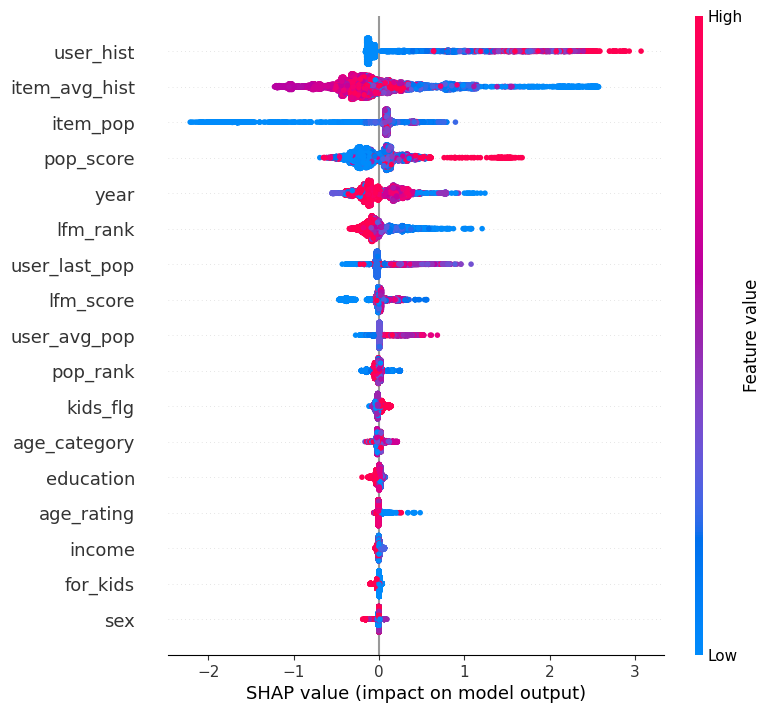

In [112]:
# summarize the effects of all the features
shap.plots.beeswarm(shap_values, max_display=len(cols))

Видим, что в целом по shap values всё нормально. Неплохо работают фичи от моделей первого уровня, особенно lfm_rank и pop_score

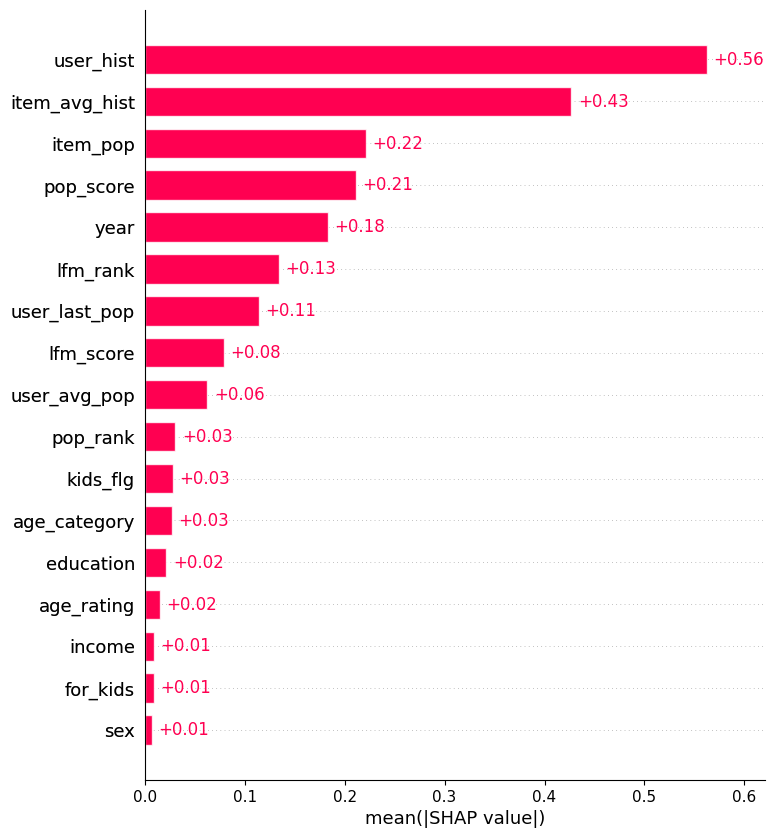

In [113]:
# mean shap-values
shap.plots.bar(shap_values, max_display=len(cols))

In [114]:
# Получаем предсказания для тестовых юзеров
y_pred: np.ndarray = pointwise_model.predict_proba(ranker_test[cols])[:, 1]
y_true: np.ndarray = np.array(ranker_test["target"])

y_pred

array([0.02716681, 0.04494119, 0.04134541, ..., 0.00167427, 0.00081054,
       0.00109833])

In [115]:
def add_score_and_rank(
    df: pd.DataFrame, y_pred_scores: np.ndarray, name: str
) -> pd.DataFrame:
    # Добавляем скор модели второго уровня
    df[f"{name}_score"] = y_pred_scores
    # Добавляем ранг модели второго уровня
    df.sort_values(
        by=["user_id", f"{name}_score"],
        ascending=[True, False],
        inplace=True,
    )
    df[f"{name}_rank"] = df.groupby("user_id").cumcount() + 1
    return df


ranker_test = add_score_and_rank(ranker_test, y_pred, "pointwise")
ranker_test.head(3)

,datetime,user_id,item_id,weight,lfm_score,lfm_rank,pop_score,pop_rank,age_category,income,sex,kids_flg,education,user_hist,user_avg_pop,user_last_pop,year,date_publication,genres,countries,staff,age_rating,for_kids,item_pop,item_avg_hist,target,pointwise_score,pointwise_rank
127,2023-04-29 09:18:05,991,5571.0,0.0,-1425.682983,3.0,1970.00,58.0,3,-1,-1,1,-1,24.0,1145.75,440.0,2018,2022-01-01T00:00:00,"[158, 261]",[238],"[4845, 17587, 30958, 11083, 6857, 2971, 881, 2...",16.0,0,1970.0,19.711675,0,0.065763,1
27,2023-05-31 08:53:35,991,1343.0,0.0,-1426.692505,66.0,1640.99,101.0,3,-1,-1,1,-1,24.0,1145.75,440.0,1989,2023-01-12T00:00:00,[261],[102],"[28535, 3068, 76, 19840, 5857, 30742]",6.0,1,1359.0,37.746873,0,0.064365,2
66,2023-04-29 09:18:05,991,2820.0,0.0,-1425.712158,4.0,3895.00,9.0,3,-1,-1,1,-1,24.0,1145.75,440.0,2004,2022-01-01T00:00:00,[261],[238],"[9540, 4845, 17587, 11083, 5536, 26849, 17882,...",16.0,0,3895.0,14.480616,0,0.063838,3


In [116]:
def avg_user_metric(
    y_true: np.ndarray,
    y_pred: np.ndarray,
    user_ids: np.ndarray,
    metric_function: Callable[[np.ndarray, np.ndarray], float],
) -> float:
    """
    Вычисляем метрику, усредненную по всем значимым (есть разные таргеты) группам.

    :param y_true: список таргетов
    :param y_pred: список предсказаний
    :param user_ids: список групп (обычно это список user_id той же размерности, что и предсказания и таргеты)
    :param metric_function: усредняемая метрика(y_true, y_pred) -> float
    :return: значение метрики metric_function, усредненное по всем значимым группам
    """
    avg_score: float = 0.0

    if len(y_pred) == len(y_true) == len(user_ids):
        l_ind: int = 0
        cur_group_id: int = user_ids[0] if len(user_ids) else 0
        n_groups: int = 0
        for r_ind, group_id in enumerate(user_ids):
            if group_id != cur_group_id or r_ind == len(user_ids) - 1:
                if r_ind == len(user_ids) - 1:
                    r_ind += 1
                # Если группа не состоит из одного и того же таргета - добавляем ее
                group_true = y_true[l_ind:r_ind]
                if not np.all(group_true == group_true[0]):
                    avg_score += metric_function(group_true, y_pred[l_ind:r_ind])
                    n_groups += 1
                l_ind = r_ind
                cur_group_id = group_id
        avg_score /= max(1, n_groups)
    else:
        raise ValueError(
            f"Размерности не совпадают: "
            f"y_pred - {len(y_pred)}, y_true - {len(y_true)}, user_ids - {len(user_ids)}"
        )
    return avg_score

In [117]:
# усредненный рок аук по юзерам
# df должен быть отсортирован по user_id
avg_user_metric(
    y_true=np.array(ranker_test["target"]),
    y_pred=np.array(ranker_test["pointwise_score"]),
    user_ids=np.array(ranker_test["user_id"]),
    metric_function=roc_auc_score,
)

0.8156425942235823

Измерим теперь метрики pointwise модели на тестовых данных ранкера (не test_data, а тех, что мы отобрали из тренировочных данных)

In [118]:
models_metrics["pointwise"] = calc_metrics_(ranker_test, "pointwise_rank")

pd.DataFrame(models_metrics)[["lfm", "pop", "pointwise"]]

,lfm,pop,pointwise
precision@10,0.007490,0.009087,0.024067
recall@10,0.031963,0.042152,0.137086
ndcg@10,0.009665,0.010474,0.027195
map@10,0.015829,0.015813,0.053975
novelty@10,7.437609,6.927668,5.402634


Видим, что есть хорошие улучшения метрик относительно обеих моделей, однако novelty снизился относительно lightfm, но это не основополагающая метрика, не страшно

# Listwise

In [119]:
# Для обучения ранжированию нужно правильно сформировать группы.
# В нашем случае группа равна одному юзеру.
# Для LGBMRanker нужно задать отсортированный по юзерам (группам) датафрейм,
# для которого списком групп будет список из количества
# ранжируемых айтемов на каждого юзера (группу).


def get_group(df: pd.DataFrame) -> np.ndarray:
    return np.array(
        df[["user_id", "item_id"]].groupby(by=["user_id"]).count()["item_id"]
    )

In [120]:
# TODO подобрать гиперпараметры

In [121]:
early_stopping_rounds = 32
params = {
    "objective": "lambdarank",  # lambdarank, оптимизирующий ndcg
    "n_estimators": 10000,  # максимальное число деревьев
    "max_depth": 4,  # максимальная глубина дерева
    "num_leaves": 10,  # число листьев << 2^max_depth
    "min_child_samples": 100,  # число примеров в листе
    "learning_rate": 0.25,  # шаг обучения
    "reg_lambda": 1,  # L2 регуляризация
    "colsample_bytree": 0.9,  # доля колонок, которая используется в каждом дереве
    "early_stopping_rounds": early_stopping_rounds,  # число итераций, в течение которых нет улучшения метрик
    "verbose": early_stopping_rounds // 8,  # период вывода метрик
    "random_state": 42,
}
fit_params = {
    "X": ranker_train[cols],
    "y": ranker_train["target"],  # target_ranker
    "group": get_group(ranker_train),
    "eval_set": [(ranker_val[cols], ranker_val["target"])],  # target_ranker
    "eval_group": [get_group(ranker_val)],
    "eval_metric": "ndcg",
    "eval_at": (3, 5, 10),
    "categorical_feature": cat_cols,
    "feature_name": cols,
}
listwise_model = LGBMRanker(**params)
listwise_model.fit(**fit_params)

[LightGBM] [Warning] early_stopping_round is set=32, early_stopping_rounds=32 will be ignored. Current value: early_stopping_round=32
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.814908
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.302741
[LightGBM] [Debug] init for col-wise cost 0.123862 seconds, init for row-wise cost 0.257868 seconds
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.162132 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Sparse Multi-Val Bin
[LightGBM] [Info] Total Bins 1656
[LightGBM] [Info] Number of data points in the train set: 2831542, number of used features: 17
[LightGBM] [Warning] early_stopping_round is set=32, early_stopping_rounds=32 will be ignored. Current value: early_stopping_round=32
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 4
Training 

LGBMRanker(colsample_bytree=0.9, early_stopping_rounds=32, learning_rate=0.25,
           max_depth=4, min_child_samples=100, n_estimators=10000,
           num_leaves=10, objective='lambdarank', random_state=42, reg_lambda=1,
           verbose=4)

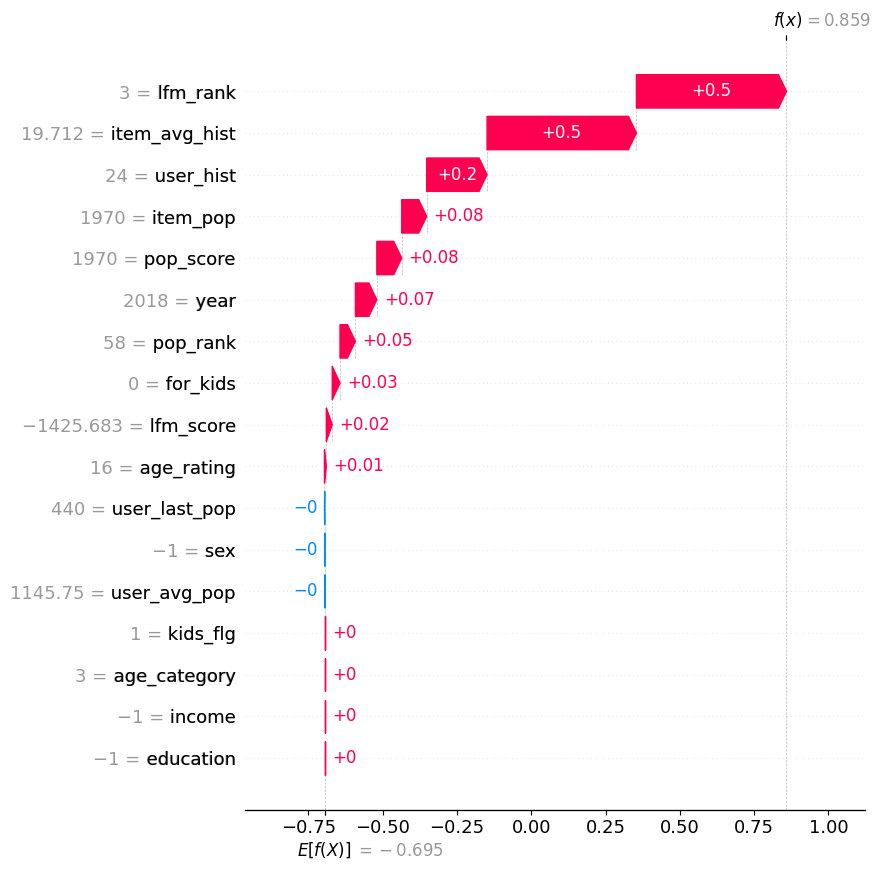

In [122]:
explainer = shap.Explainer(listwise_model)
shap_values = explainer(ranker_test[cols].iloc[:10_000])

shap.plots.waterfall(shap_values[0], max_display=len(cols))

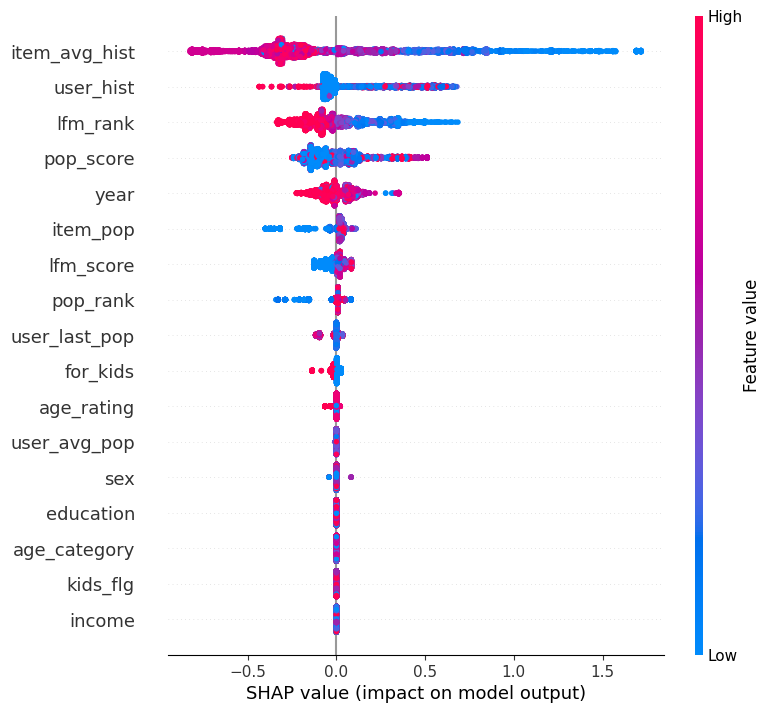

In [123]:
# summarize the effects of all the features
shap.plots.beeswarm(shap_values, max_display=len(cols))

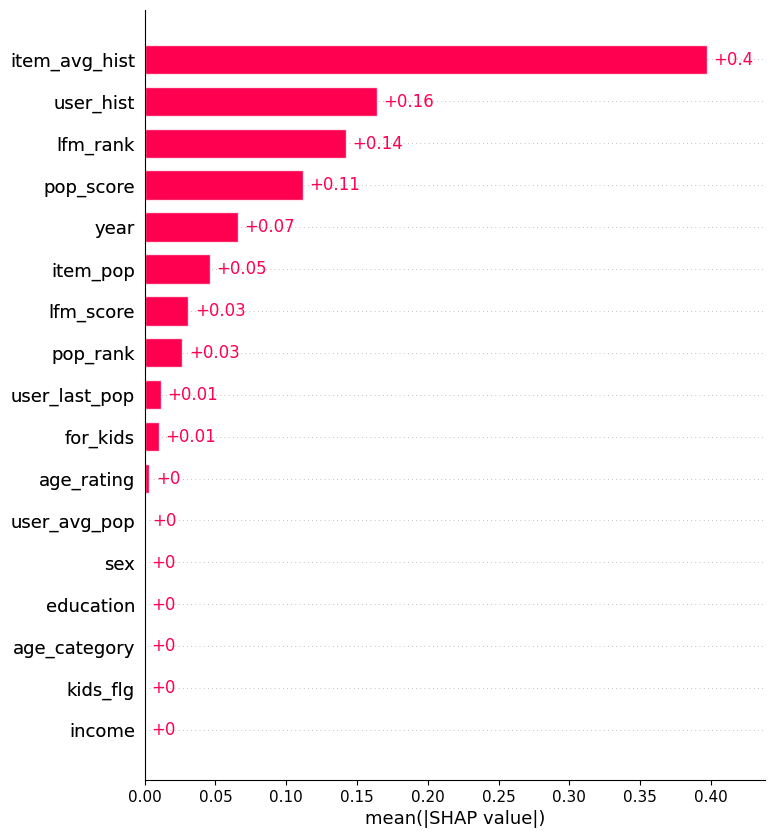

In [124]:
# mean shap-values
shap.plots.bar(shap_values, max_display=len(cols))

Видим не использованные признаки, это может означать, что в бустинге мало деревьев. Надо бы перепроверить модель или подобрать другие гиперпараметры

In [125]:
y_pred: np.ndarray = listwise_model.predict(ranker_test[cols])
ranker_test = add_score_and_rank(ranker_test, y_pred, "listwise")
ranker_test.head(3)

,datetime,user_id,item_id,weight,lfm_score,lfm_rank,pop_score,pop_rank,age_category,income,sex,kids_flg,education,user_hist,user_avg_pop,user_last_pop,year,date_publication,genres,countries,staff,age_rating,for_kids,item_pop,item_avg_hist,target,pointwise_score,pointwise_rank,listwise_score,listwise_rank
127,2023-04-29 09:18:05,991,5571.0,0.0,-1425.682983,3.0,1970.0,58.0,3,-1,-1,1,-1,24.0,1145.75,440.0,2018,2022-01-01T00:00:00,"[158, 261]",[238],"[4845, 17587, 30958, 11083, 6857, 2971, 881, 2...",16.0,0,1970.0,19.711675,0,0.065763,1,0.858736,1
23,2023-04-29 09:18:05,991,1226.0,0.0,-1425.862671,10.0,2673.0,27.0,3,-1,-1,1,-1,24.0,1145.75,440.0,2011,2022-01-01T00:00:00,"[158, 261]",[238],"[13165, 11604, 3722, 21988, 32097, 23400, 2692...",16.0,0,2673.0,17.870183,0,0.037229,27,0.745060,2
25,2023-04-29 09:18:05,991,1281.0,0.0,-1800.806265,101.0,2908.0,22.0,3,-1,-1,1,-1,24.0,1145.75,440.0,2021,2023-03-03T00:00:00,"[97, 303, 294]","[121, 102]","[11572, 2515, 26948, 13185, 2114]",16.0,0,2908.0,10.660935,0,0.026782,65,0.702295,3


In [126]:
models_metrics["listwise"] = calc_metrics_(ranker_test, "listwise_rank")
pd.DataFrame(models_metrics)

,lfm,pop,pointwise,listwise
precision@10,0.007490,0.009087,0.024067,0.024561
recall@10,0.031963,0.042152,0.137086,0.142872
ndcg@10,0.009665,0.010474,0.027195,0.027896
map@10,0.015829,0.015813,0.053975,0.056091
novelty@10,7.437609,6.927668,5.402634,5.388651


In [127]:
avg_user_metric(
    y_true=np.array(ranker_test["target"]),  # target_ranker
    y_pred=np.array(ranker_test["listwise_score"]),
    user_ids=np.array(ranker_test["user_id"]),
    metric_function=roc_auc_score,
)

0.8040524830154541

# Теперь посчитаем итоговые метрики на тестовой части (test_data.csv)

In [128]:
test_data

,user_id,item_ids
0,0,"[12.0, 6201.0, 5542.0, 2025.0, 190.0, 5358.0, ..."
1,1,"[2515.0, 1540.0, 5210.0, 1608.0, 3590.0, 7215...."
2,2,"[5998.0, 190.0, 7327.0, 947.0, 3814.0, 876.0, ..."
3,3,"[4812.0, 3935.0, 802.0, 4459.0, 4340.0, 5975.0..."
4,4,"[152.0, 195.0, 800.0, 2266.0, 6634.0, 7412.0, ..."
...,...,...
66895,176506,[1515.0]
66896,176519,[4167.0]
66897,176525,[5947.0]
66898,176531,[5514.0]


### Подготовим фичи для ранкера для тестового набора данных

In [129]:
candidates[candidates["user_id"] == test_data["user_id"][0]]

,user_id,item_id,lfm_score,lfm_rank,pop_score,pop_rank
0,0,65.0,-1800.806265,101.0,1901.00,68.0
1,0,74.0,-1561.063477,35.0,1640.99,101.0
2,0,107.0,-1561.179932,41.0,1640.99,101.0
3,0,130.0,-1560.512939,12.0,1640.99,101.0
4,0,158.0,-1800.806265,101.0,2117.00,49.0
...,...,...,...,...,...,...
186,0,7173.0,-1800.806265,101.0,3155.00,20.0
187,0,7328.0,-1800.806265,101.0,1974.00,57.0
188,0,7338.0,-1800.806265,101.0,1695.00,90.0
189,0,7412.0,-1561.616577,81.0,1640.99,101.0


In [130]:
test_user = add_features(candidates[candidates["user_id"] == test_data["user_id"][0]])
y_pred_listwise: np.ndarray = listwise_model.predict(test_user[cols])
test_user = add_score_and_rank(test_user, y_pred_listwise, "listwise")
list(test_user[test_user["listwise_rank"] <= 10]["item_id"])

[1281.0,
 1226.0,
 5849.0,
 4176.0,
 4505.0,
 2820.0,
 3707.0,
 3896.0,
 1996.0,
 3323.0]

In [131]:
test_candidates_data = add_features(
    candidates[candidates["user_id"].isin(test_data["user_id"].unique())]
)

### Pointwise

In [132]:
%%time
y_pred_pointwise: np.ndarray = pointwise_model.predict_proba(
    test_candidates_data[cols]
)[:, 1]

CPU times: user 21.2 s, sys: 812 ms, total: 22 s
Wall time: 6.62 s


In [133]:
test_candidates_data = add_score_and_rank(
    test_candidates_data, y_pred_pointwise, "pointwise"
)

In [134]:
test_candidates_data.sort_values(["user_id", "pointwise_rank"], inplace=True)

In [135]:
result_recos_test = convert_recos(test_candidates_data, "pointwise_recos")

In [136]:
merged_test = pd.merge(merged_test, result_recos_test, on="user_id", how="left")

In [137]:
evaluate_recommender(
    df=merged_test, model_preds_col="pointwise_recos", gt_col="item_ids"
)

{'ndcg': 0.16105680153374358, 'recall': 0.08447099066277143}

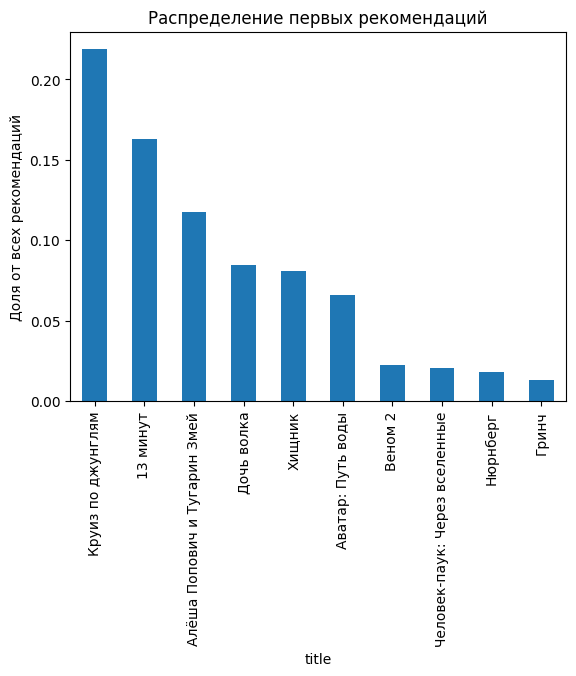

In [138]:
first_recos = pd.DataFrame(
    [x[0] for x in merged_test["pointwise_recos"].values], columns=["item_id"]
)
first_items = (
    first_recos.merge(items_titles, on="item_id")
    .groupby("title")
    .size()
    .sort_values(ascending=False)
)
first_items /= first_items.sum()
first_items.head(10).plot(kind="bar")
plt.ylabel("Доля от всех рекомендаций")
plt.title("Распределение первых рекомендаций")
plt.show()

Здесь мы видим гораздо более разнообразные рекомендации, при этом аватар сильно сместился с первого места

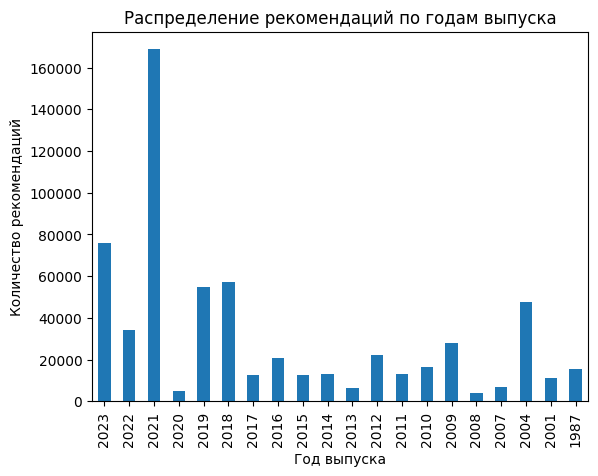

In [139]:
year_distribution = merged_test.explode("pointwise_recos").merge(
    items[["item_id", "year"]], left_on="pointwise_recos", right_on="item_id"
)
year_distribution["year"].value_counts().nlargest(20).sort_index(ascending=False).plot(
    kind="bar"
)

plt.ylabel("Количество рекомендаций")
plt.xlabel("Год выпуска")
plt.title("Распределение рекомендаций по годам выпуска")
plt.show()

Тут мы видим интересный момент, что кол-во рекомендаций 2022-23 годов сильно снизилось, но повысилось для 2021 года. Кстати, феномен рекомендаций фильмов из 2011 у lightfm ушёл.

### Listwise

In [140]:
y_pred_listwise: np.ndarray = listwise_model.predict(test_candidates_data[cols])

In [141]:
test_candidates_data = add_score_and_rank(
    test_candidates_data, y_pred_listwise, "listwise"
)

In [142]:
test_candidates_data.sort_values(["user_id", "listwise_rank"], inplace=True)

In [143]:
result_recos_test = convert_recos(test_candidates_data, "listwise_recos")

In [144]:
merged_test = pd.merge(merged_test, result_recos_test, on="user_id", how="left")

In [145]:
evaluate_recommender(
    df=merged_test, model_preds_col="listwise_recos", gt_col="item_ids"
)

{'ndcg': 0.1841126593056287, 'recall': 0.09531521185808066}

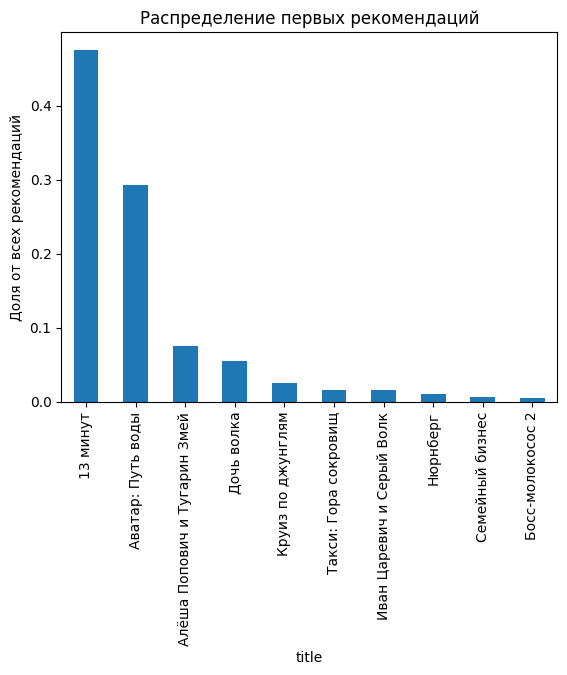

In [146]:
first_recos = pd.DataFrame(
    [x[0] for x in merged_test["listwise_recos"].values], columns=["item_id"]
)
first_items = (
    first_recos.merge(items_titles, on="item_id")
    .groupby("title")
    .size()
    .sort_values(ascending=False)
)
first_items /= first_items.sum()
first_items.head(10).plot(kind="bar")
plt.ylabel("Доля от всех рекомендаций")
plt.title("Распределение первых рекомендаций")
plt.show()

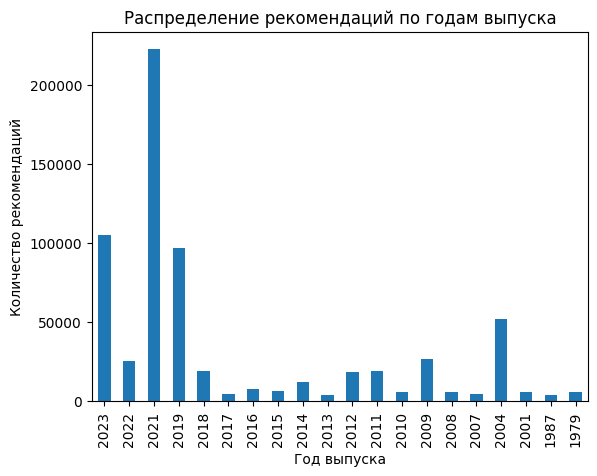

In [147]:
year_distribution = merged_test.explode("listwise_recos").merge(
    items[["item_id", "year"]], left_on="listwise_recos", right_on="item_id"
)
year_distribution["year"].value_counts().nlargest(20).sort_index(ascending=False).plot(
    kind="bar"
)

plt.ylabel("Количество рекомендаций")
plt.xlabel("Год выпуска")
plt.title("Распределение рекомендаций по годам выпуска")
plt.show()

Здесь видим резко возросшее кол-во рекомендаций фильмов из 2021 относительно прошлой модели. Здесь мы в целом видим менее разнообразные рекомендации, вероятно early stopping сработал рано и бустинг получился не сильно большой. Тем не менее, модель получилась довольно интересная, и по метрикам бьёт все остальные. Большое кол-во рекомендаций из 2021 объясняется тем, что фильм 13 минут, который наша модель рекомендует всем на первом месте, снят в 2021.

### Итоговые рекомендации

In [148]:
merged_test

,user_id,item_ids,lightfm_recos,popular_recos,pointwise_recos,listwise_recos
0,0,"[12.0, 6201.0, 5542.0, 2025.0, 190.0, 5358.0, ...","[4469.0, 1996.0, 4254.0, 4176.0, 5466.0, 6195....","[484.0, 6194.0, 2679.0, 5876.0, 5336.0, 2074.0...","[2820.0, 7426.0, 5571.0, 3896.0, 7113.0, 5021....","[1281.0, 1226.0, 5849.0, 4176.0, 4505.0, 2820...."
1,1,"[2515.0, 1540.0, 5210.0, 1608.0, 3590.0, 7215....","[5779.0, 484.0, 1978.0, 5707.0, 5918.0, 5876.0...","[484.0, 6194.0, 2679.0, 5876.0, 5336.0, 2074.0...","[4991.0, 5774.0, 1978.0, 5918.0, 2052.0, 3204....","[484.0, 1281.0, 3122.0, 2057.0, 5281.0, 1647.0..."
2,2,"[5998.0, 190.0, 7327.0, 947.0, 3814.0, 876.0, ...","[484.0, 6194.0, 2480.0, 2679.0, 2074.0, 1978.0...","[484.0, 6194.0, 2679.0, 5876.0, 5336.0, 2074.0...","[5774.0, 1514.0, 1978.0, 3347.0, 805.0, 4991.0...","[1281.0, 4991.0, 484.0, 6194.0, 805.0, 475.0, ..."
3,3,"[4812.0, 3935.0, 802.0, 4459.0, 4340.0, 5975.0...","[4469.0, 2997.0, 4581.0, 6172.0, 4308.0, 5512....","[484.0, 6194.0, 2679.0, 5876.0, 5336.0, 2074.0...","[2820.0, 3896.0, 4340.0, 1281.0, 7426.0, 1226....","[1281.0, 1226.0, 2820.0, 3323.0, 5754.0, 4581...."
4,4,"[152.0, 195.0, 800.0, 2266.0, 6634.0, 7412.0, ...","[4469.0, 3812.0, 444.0, 3434.0, 810.0, 4687.0,...","[484.0, 6194.0, 2679.0, 5876.0, 5336.0, 2074.0...","[2820.0, 3896.0, 5519.0, 4486.0, 1226.0, 4340....","[1281.0, 1226.0, 4762.0, 2820.0, 3896.0, 5045...."
...,...,...,...,...,...,...
66895,176506,[1515.0],"[6241.0, 7339.0, 1522.0, 6402.0, 1164.0, 453.0...","[484.0, 6194.0, 2679.0, 5876.0, 5336.0, 2074.0...","[1281.0, 5849.0, 6194.0, 4991.0, 641.0, 484.0,...","[5849.0, 1281.0, 484.0, 641.0, 6194.0, 4505.0,..."
66896,176519,[4167.0],"[4469.0, 4254.0, 1226.0, 484.0, 451.0, 2820.0,...","[484.0, 6194.0, 2679.0, 5876.0, 5336.0, 2074.0...","[2820.0, 1226.0, 209.0, 3509.0, 484.0, 1281.0,...","[2820.0, 1226.0, 484.0, 1281.0, 5849.0, 641.0,..."
66897,176525,[5947.0],"[6194.0, 5336.0, 4090.0, 484.0, 5712.0, 1281.0...","[484.0, 6194.0, 2679.0, 5876.0, 5336.0, 2074.0...","[5849.0, 1281.0, 641.0, 6194.0, 4991.0, 484.0,...","[1281.0, 5849.0, 6194.0, 4505.0, 641.0, 484.0,..."
66898,176531,[5514.0],"[6194.0, 484.0, 5336.0, 4090.0, 5712.0, 1281.0...","[484.0, 6194.0, 2679.0, 5876.0, 5336.0, 2074.0...","[5849.0, 1281.0, 641.0, 6194.0, 484.0, 4991.0,...","[1281.0, 5849.0, 6194.0, 484.0, 641.0, 4505.0,..."


In [149]:
print("LightFM")
evaluate_recommender(df=merged_test, model_preds_col="lightfm_recos", gt_col="item_ids")

LightFM


{'ndcg': 0.08221231459381445, 'recall': 0.038269079196678685}

In [150]:
print("Popular")
evaluate_recommender(df=merged_test, model_preds_col="popular_recos", gt_col="item_ids")

Popular


{'ndcg': 0.08071575541377207, 'recall': 0.03563382489856545}

In [151]:
print("Pointwise")
evaluate_recommender(
    df=merged_test, model_preds_col="pointwise_recos", gt_col="item_ids"
)

Pointwise


{'ndcg': 0.16105680153374358, 'recall': 0.08447099066277143}

In [152]:
print("Listwise")
evaluate_recommender(
    df=merged_test, model_preds_col="listwise_recos", gt_col="item_ids"
)

Listwise


{'ndcg': 0.1841126593056287, 'recall': 0.09531521185808066}

Здесь мы можем увидеть, что по метрикам со значимым отрывом от остальных моделей побеждает Listwise ранкер. Тем не менее, с этой моделью наблюдаются некоторые проблемы, так как рекомендации не сильно разнообразные. Скорее всего тюнинг гиперпараметров решит проблему

In [153]:
# TODO разобраться с listwise ранкером